# Environmental Sound Classification (UrbanSound8K dataset)

## Goal
Build RNN and Transformer model that can identify 10 types of urban sounds from UrbanSound8K dataset. 

## 0. Imports

In [104]:
!pip install soundata
!pip install torchaudio

In [128]:
import soundata
import numpy as np
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import librosa
import pandas as pd
import random
from IPython.display import Audio, display, HTML
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from sklearn.metrics import f1_score, confusion_matrix

In [156]:
seed = 73
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1. Data preparation

In [107]:
class DataLoader:
    def __init__(self,config):
        self.config = config
        self.dataset = None
        self.clips = None 
        self.feature_data = {
            'train': {'features':[],'labels':[],'folds':[]},
            'val':{'features':[],'labels':[],'folds':[]},
            'test':{'features':[],'labels':[],'folds':[]}
        }

    def download_and_validate(self):
        print("Initializing dataset")
        self.dataset = soundata.initialize('urbansound8k')

        try:
            # in case it is already downloaded
            print("Validating dataset")
            self.dataset.validate()
        except Exception as e:
            print("Downloading dataset")
            self.dataset.download()

        self.clips = self.dataset.load_clips()
        print(f"Loaded {len(self.clips)} audio clips")

    def get_fold_number(self,clip_id):
        clip = self.clips[clip_id]
        if hasattr(clip, '_clip_metadata'):
            metadata = clip._clip_metadata
            if isinstance(metadata, dict) and 'fold' in metadata:
                return int(metadata['fold'])
                
    def preprocess_audio(self, audio, original):
        # 1. resample audio to standardize inputs ensuring all audio files have same sample rate for consistent processing
        if original != self.config['sample_rate']:
            # initialize pytorch resampler with original and target sample rates
            resampler = torchaudio.transforms.Resample(
                orig_freq=original,                     # original sample rate
                new_freq=self.config['sample_rate']     # target sample rate
            )

            audio = resampler(torch.tensor(audio).float()).numpy()
        
        # 2. channel normalization 
        # converting to mono if multi channel so it could train faster and it is better for sound recognition
        if audio.ndim > 1:
            audio = librosa.to_mono(audio)
        # 3. duration standarization
        # target length = duration * sample rate
        target_samples = int(self.config['max_duration'] * self.config['sample_rate'])
        
        # case1: audio is shorter than target duration
        if len(audio) < target_samples:
            # calculate padding needed (only at end of audio)
            pad_amount = target_samples - len(audio)
            # add zero padding (silence) at the end
            audio = np.pad(audio, (0, pad_amount))
        
        # case2: audio is longer than target duration
        else:
            # truncate to the target length (keep beginning portion)
            audio = audio[:target_samples]
        return audio
    
    def extract_features(self,audio):
        # mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,  
            sr=self.config['sample_rate'], 
            n_fft=self.config['n_fft'],  
            hop_length=self.config['hop_length'],  
            n_mels=self.config['n_mels']  
        )
        # convert power spectrogram to dB scale (log transform) which matches human hearing's perception
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)

        # RMS -> per frame loudness estimate
        energy = librosa.feature.rms(
            y=audio,
            frame_length=self.config['n_fft'],  
            hop_length=self.config['hop_length']
        )

        # MFCCs -> Mel Frequency Cepstral Coefficients
        # compact spectral representation
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=self.config['sample_rate'],
            n_mfcc=self.config['n_mfcc'],  
            n_fft=self.config['n_fft'],
            hop_length=self.config['hop_length']
        )
        return {
            'waveform': audio,  
            'log_mel': log_mel,
            'energy': energy,  
            'mfcc': mfcc  
        }
    def process_dataset(self):
        print("Processing dataset")
        for clip_id, clip in tqdm(self.clips.items()):
            audio, sr = clip.audio
            fold = self.get_fold_number(clip_id)
            class_name = clip.tags.labels[0]
            
            audio = self.preprocess_audio(audio, sr)
            features = self.extract_features(audio)
            
            split = self.get_split(fold)
            if split:
                self.feature_data[split]['features'].append(features)
                self.feature_data[split]['labels'].append(class_name)
                self.feature_data[split]['folds'].append(fold)

    def get_split(self, fold):
        if fold in self.config['train_folds']:
            return 'train'
        elif fold in self.config['val_folds']:
            return 'val'
        elif fold in self.config['test_folds']:
            return 'test'
        return None
    
    def get_processed_data(self):
        return {
            'train': {
                'features': np.array(self.feature_data['train']['features']),
                'labels': np.array(self.feature_data['train']['labels']),
                'folds': np.array(self.feature_data['train']['folds'])
            },
            'val': {
                'features': np.array(self.feature_data['val']['features']),
                'labels': np.array(self.feature_data['val']['labels']),
                'folds': np.array(self.feature_data['val']['folds'])
            },
            'test': {
                'features': np.array(self.feature_data['test']['features']),
                'labels': np.array(self.feature_data['test']['labels']),
                'folds': np.array(self.feature_data['test']['folds'])
            }
        }

In [108]:
config = {
    'sample_rate': 16000,
    'max_duration': 4.0,
    'n_fft': 2048,
    'hop_length': 512,
    'n_mels': 64,
    'n_mfcc': 20,
    'train_folds': list(range(1, 7)),
    'val_folds': [7, 8],
    'test_folds': [9, 10],
    'resample': True
}

data_loader = DataLoader(config)
data_loader.download_and_validate()
data_loader.process_dataset()

Initializing dataset
Validating dataset


100%|██████████| 8732/8732 [00:17<00:00, 493.84it/s]


Loaded 8732 audio clips
Processing dataset


100%|██████████| 8732/8732 [03:27<00:00, 42.15it/s]


In [110]:
processed_data = data_loader.get_processed_data()

# training data
train_features = processed_data['train']['features']
train_labels = processed_data['train']['labels']
train_folds = processed_data['train']['folds']

# validation data
val_features = processed_data['val']['features']
val_labels = processed_data['val']['labels']
val_folds = processed_data['val']['folds']

# test data
test_features = processed_data['test']['features']
test_labels = processed_data['test']['labels']
test_folds = processed_data['test']['folds']

In [111]:
# dataset statistics
print("\nDataset statistics:")
print(f"Training set: {len(train_features)} samples")
print(f"Validation set: {len(val_features)} samples")
print(f"Test set: {len(test_features)} samples")

# sample shapes
print("\nFeature Shapes (first sample):")
print(f"Waveform: {train_features[0]['waveform'].shape}")
print(f"Log Mel: {train_features[0]['log_mel'].shape}")
print(f"MFCCs: {train_features[0]['mfcc'].shape}")
print(f"Energy: {train_features[0]['energy'].shape}")

# class distribution in each set 
print("\nClass distribution:")
print(f"Training classes: {np.unique(train_labels)}")
print(f"Validation classes: {np.unique(val_labels)}")
print(f"Test classes: {np.unique(test_labels)}")

# fold distribution
print("\nFold distribution:")
print(f"Training folds: {np.unique(train_folds)}")
print(f"Validation folds: {np.unique(val_folds)}")
print(f"Test folds: {np.unique(test_folds)}")


Dataset statistics:
Training set: 5435 samples
Validation set: 1644 samples
Test set: 1653 samples

Feature Shapes (first sample):
Waveform: (64000,)
Log Mel: (64, 126)
MFCCs: (20, 126)
Energy: (1, 126)

Class distribution:
Training classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
Validation classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
Test classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']

Fold distribution:
Training folds: [1 2 3 4 5 6]
Validation folds: [7 8]
Test folds: [ 9 10]


## 1.2 Visualizations and Analysis

In [112]:
# helper functions
def class_palette(labels):
    classes = sorted(np.unique(labels).tolist())
    class_palette = sns.color_palette("husl", len(classes))
    return dict(zip(classes, class_palette))

def plot_class_distribution(labels, title, ax=None, color_dict=None):
    if ax is None:
        _,ax = plt.subplots(figsize=(12,6))

    class_counts = Counter(labels)
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]
    if color_dict is None:
        color_dict = class_palette(labels)
    colors = [color_dict[c] for c in classes]

    # bar plots 
    sns.barplot(x=classes,y=counts,ax=ax,palette=colors,hue=classes,legend=False,dodge=False)
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # count labels 
    for i,p in enumerate(ax.patches):
        ax.annotate(f'{counts[i]}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', 
            xytext=(0, 7), 
            textcoords='offset points',
            fontsize=9)

### 1.2.1 Playing Samples

In [114]:
def play_audio(features_list, labels, sample_rate, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    classes = np.unique(labels)
    print(colored("\nCLASS AUDIO EXAMPLES", "blue", attrs=["bold", "underline"]))
    for c in classes:
        classes_indices = np.where(labels == c)[0]
        i = random.choice(classes_indices)
        waveform = features_list[i]['waveform']
        class_header = colored(f"   Class: {c}","magenta", attrs=["bold"])
        sample_info = colored(f" (Sample {i})","green")
        print(f"{class_header}{sample_info}")
        display(Audio(data=waveform,rate=sample_rate))


In [115]:
play_audio(features_list=train_features,labels=train_labels,sample_rate=config['sample_rate'],seed=42)


CLASS AUDIO EXAMPLES
   Class: air_conditioner (Sample 1009)


   Class: car_horn (Sample 472)


   Class: children_playing (Sample 2502)


   Class: dog_bark (Sample 2292)


   Class: drilling (Sample 1924)


   Class: engine_idling (Sample 1475)


   Class: gun_shot (Sample 4673)


   Class: jackhammer (Sample 737)


   Class: siren (Sample 4756)


   Class: street_music (Sample 795)


### 1.2.2 Dataset Statistics

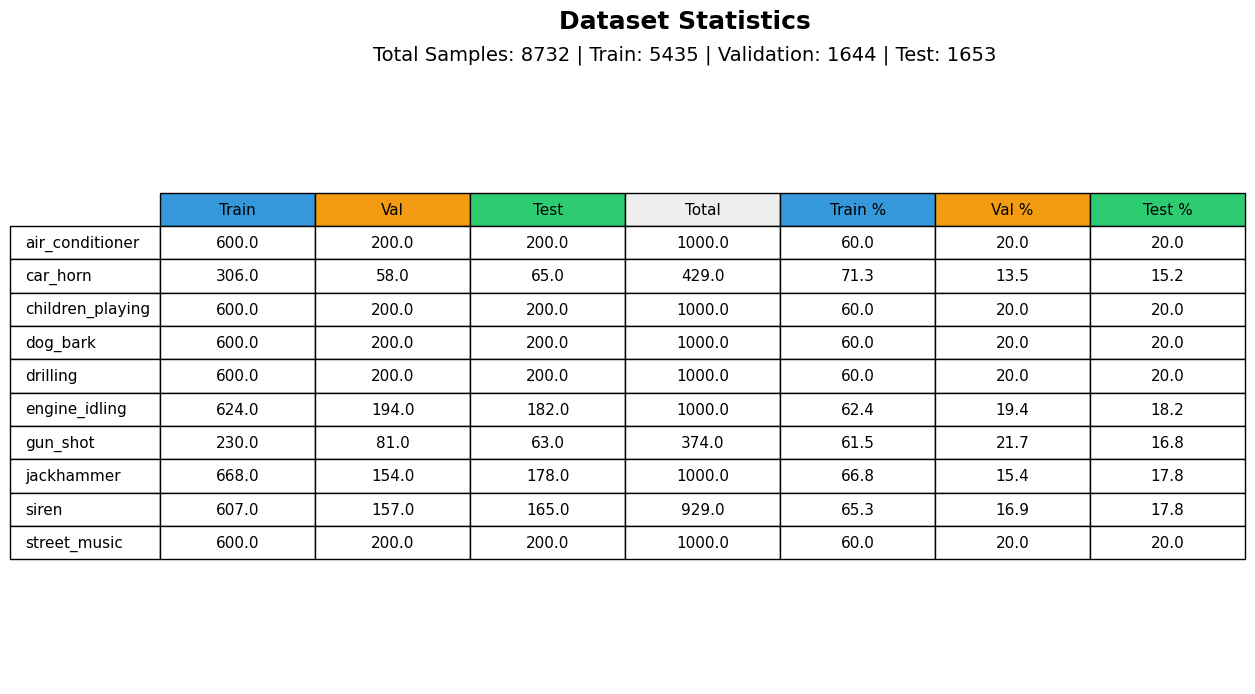

In [116]:
all_labels = np.concatenate([train_labels, val_labels, test_labels])
unique_labels = sorted(np.unique(all_labels).tolist())
stats_data = []
for i in unique_labels:
    stats_data.append([np.sum(train_labels==i),np.sum(val_labels==i),np.sum(test_labels==i),np.sum(all_labels == i)])

stats_df = pd.DataFrame(stats_data, index=unique_labels,columns=['Train', 'Validation', 'Test', 'Total'])

stats_df['Train %'] = (stats_df['Train'] / stats_df['Total'] * 100).round(1)
stats_df['Val %'] = (stats_df['Validation'] / stats_df['Total'] * 100).round(1)
stats_df['Test %'] = (stats_df['Test'] / stats_df['Total'] * 100).round(1)

plt.figure(figsize=(14, 8))
ax = plt.gca()
ax.axis('off')
table = plt.table(
    cellText=stats_df.values,
    rowLabels=stats_df.index,
    colLabels=['Train', 'Val', 'Test', 'Total', 'Train %', 'Val %', 'Test %'],
    cellLoc='center',
    loc='center',
    colColours=['#3498db', '#f39c12', '#2ecc71', '#eeeeee', '#3498db', '#f39c12', '#2ecc71']
)

table.set_fontsize(11)
table.scale(1,2)
plt.figtext(0.5, 0.93, 'Dataset Statistics', ha='center', fontsize=18, weight='bold')
plt.figtext(0.5, 0.89, f"Total Samples: {len(all_labels)} | "
                      f"Train: {len(train_labels)} | "
                      f"Validation: {len(val_labels)} | "
                      f"Test: {len(test_labels)}", 
           ha='center', fontsize=14)

plt.show()

### 1.2.3 Class Distribution Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


AttributeError: Rectangle.set() got an unexpected keyword argument 'legend'

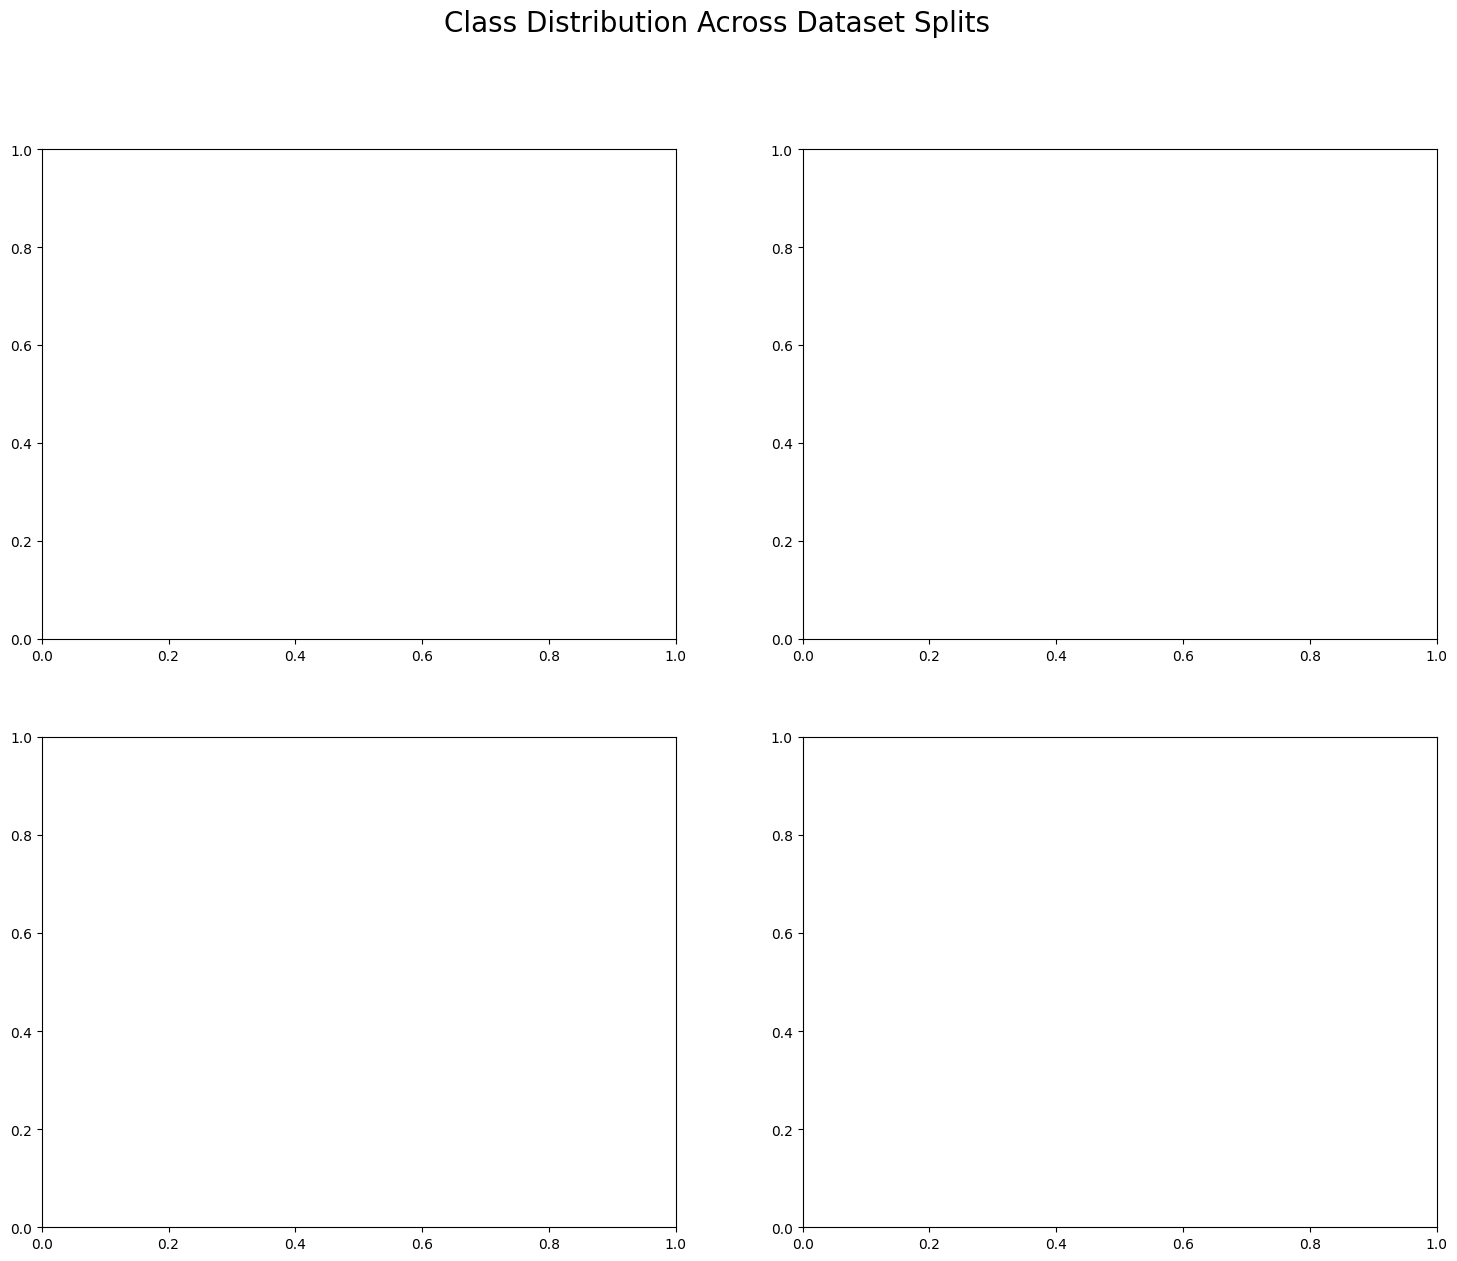

In [117]:
all_labels = np.concatenate([train_labels, val_labels, test_labels])
fig1, axs1 = plt.subplots(2, 2, figsize=(18, 14))
fig1.suptitle('Class Distribution Across Dataset Splits', fontsize=20, y=0.98)

plot_class_distribution(labels=train_labels, 
                       title='Training Set', 
                       ax=axs1[0, 0])

plot_class_distribution(labels=val_labels, 
                       title='Validation Set', 
                       ax=axs1[0, 1])

plot_class_distribution(labels=test_labels, 
                       title='Test Set', 
                       ax=axs1[1, 0])

plot_class_distribution(labels=all_labels, 
                       title='Overall Dataset', 
                       ax=axs1[1, 1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 1.2.4 Waveform & Spectrogram Plots

In [ ]:
def plot_waveform(audio,sample_rate,title="Waveform",ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,3))

    time = np.linspace(0,len(audio)/sample_rate,len(audio))
    ax.plot(time,audio)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("Amplitude",fontsize=10)
    ax.set_xlim(0, time[-1])
    ax.grid(alpha=0.3)
    return ax

def plot_mel_spectrogram(log_mel,sample_rate,hop_length,title="Mel Spectrogram",ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,4))
    else:
        fig = ax.figure

    img = librosa.display.specshow(log_mel, sr=sample_rate,hop_length=hop_length,x_axis='time',y_axis='mel',ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("Frequency (Hz)",fontsize=10)
    fig.colorbar(img,ax=ax,format="%+2.0f dB")
    return ax

def plot_energy(energy,sample_rate,hop_length,title="Energy (RMS)",ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))
    times = librosa.times_like(energy,sr=sample_rate,hop_length=hop_length)
    ax.plot(times, energy.flatten(),color='r',linewidth=1.5)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("Energy",fontsize=10)
    ax.set_xlim(0, times[-1])
    ax.grid(alpha=0.3)
    return ax

def plot_mfcc(mfcc,sample_rate,hop_length,title="MFCCs",ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        fig = ax.figure
    
    img = librosa.display.specshow(mfcc,sr=sample_rate,hop_length=hop_length,x_axis='time',ax=ax,cmap='coolwarm')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("MFCC Coefficients",fontsize=10)
    fig.colorbar(img, ax=ax)
    return ax

def plot_all(feature_dict,sample_rate,hop_length,class_name=""):
    fig,axs = plt.subplots(4,1,figsize=(12,10),sharex=True)
    fig.suptitle(f"{class_name}",fontsize=16,y=0.98)

    plot_waveform(feature_dict['waveform'], sample_rate, title="Waveform", ax=axs[0])
    plot_mel_spectrogram(feature_dict['log_mel'], sample_rate, hop_length, title="Mel Spectrogram", ax=axs[1])
    plot_energy(feature_dict['energy'], sample_rate, hop_length, title="Energy (RMS)", ax=axs[2])
    plot_mfcc(feature_dict['mfcc'], sample_rate, hop_length, title="MFCCs", ax=axs[3])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    return fig

def plot_classes(features_list,labels,sample_rate,hop_length,n_classes=5):
    classes = np.unique(labels)[:n_classes]
    fig, axs = plt.subplots(n_classes,4,figsize=(16,3*n_classes))
    fig.suptitle("Classes Feature Analysis",fontsize=20,y=0.98)
    
    for i, c in enumerate(classes):
        idx = np.where(labels == c)[0][0]
        features = features_list[idx]
        plot_waveform(features['waveform'], sample_rate, f"{c} Waveform", ax=axs[i, 0])
        plot_mel_spectrogram(features['log_mel'], sample_rate, hop_length, f"{c} Mel Spectrogram", ax=axs[i, 1])
        plot_energy(features['energy'], sample_rate, hop_length, f"{c} Energy", ax=axs[i, 2])
        plot_mfcc(features['mfcc'], sample_rate, hop_length, f"{c} MFCCs", ax=axs[i, 3])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    return fig

In [ ]:
sample = 42
features = train_features[sample]
class_name = train_labels[sample]

plot_all(features,sample_rate=config['sample_rate'],hop_length=config['hop_length'],class_name=f"{class_name} (Sample {sample})")
plt.show()

In [ ]:
plot_classes(
    features_list=train_features,
    labels=train_labels,
    sample_rate=config['sample_rate'],
    hop_length=config['hop_length'],
    n_classes=5
)
plt.show()

## 2. Building the Model

### 2.1 RNN Model

In [ ]:
class SoundClassifierRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional = True, num_classes = 10):
        super(SoundClassifierRNN, self).__init__()
        self.rnn = nn.RNN(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          bidirectional = bidirectional,
                          batch_first = True)
        
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)
        self.dropout = nn.Dropout(p = 0.6)
        
    def forward(self, x):
        # x: [batch_size, time_steps, input_size]
        out, _ = self.rnn(x)           # out: [batch_size, time_steps, hidden_size]
        out, _ = out.max(dim=1)        # use element_wise max for all hidden states (e.g. like what happem in sentiment classification)
        out = self.dropout(out)
        out = self.fc(out)             # out: [batch_size, num_classes]
        return out

In [ ]:
num_layers_list = [1, 2, 3, 4]
hidden_sizes_list = [32, 64, 128, 256]
features = [
    "log_mel",
    "mfcc",
    "energy"
]
num_epochs = 100
batch_size = 60

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
classes = np.unique(train_labels)
class_to_index = {name: idx for idx, name in enumerate(classes)}
train_labels_idx = np.array([class_to_index[name] for name in train_labels])
val_labels_idx   = np.array([class_to_index[name] for name in val_labels])
test_labels_idx  = np.array([class_to_index[name] for name in test_labels])

print(train_labels_idx)
print(val_labels_idx)
print(test_labels_idx)

In [157]:
from torch.utils.data import TensorDataset, DataLoader
results_rnn = []

os.makedirs("saved_models", exist_ok=True)
for feature_name in features:
    print(f"\n=== Feature: {feature_name} ===")
    
    X_train_np = np.stack([x[feature_name] for x in train_features])
    X_train_np = np.transpose(X_train_np, (0, 2, 1))
    X_val_np = np.stack([x[feature_name] for x in val_features])
    X_val_np = np.transpose(X_val_np, (0, 2, 1))
    
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(train_labels_idx, dtype=torch.long)

    X_val = torch.tensor(X_val_np, dtype=torch.float32)
    y_val = torch.tensor(val_labels_idx, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size = batch_size, shuffle = False)

    for num_layers in num_layers_list:
        for hidden_size in hidden_sizes_list:
            print(f"\n>> Layers: {num_layers}, Hidden size: {hidden_size}")
            best_val_acc = 0.0
            model_filename = f"saved_models/model_{feature_name}_L{num_layers}_H{hidden_size}.pth"

            model = SoundClassifierRNN(
                input_size = X_train.shape[2],
                hidden_size = hidden_size,
                num_layers = num_layers
            ).to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.00016667)  # lr = 0.01/60            
            for epoch in range(num_epochs):
                model.train()
                train_loss = 0
                correct = 0
                total = 0
                for inputs, labels in train_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                avg_train_loss = train_loss / total
                train_acc = 100. * correct / total

                # === Validation ===
                model.eval()
                val_loss = 0
                correct = 0
                total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        val_loss += loss.item() * inputs.size(0)
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()

                avg_val_loss = val_loss / total
                val_acc = 100. * correct / total

                print(f"Epoch [{epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                      f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    torch.save(model.state_dict(), model_filename)

                results_rnn.append({
                     'Epoch': epoch,
                     'Feature': feature_name,
                     'Num_Layers': num_layers,
                     'Hidden_Size': hidden_size,
                     'Train_Acc': train_acc,
                     'Val_Acc': val_acc,
                     'Train_Loss': avg_train_loss,
                     'Val_Loss': avg_val_loss
                 })


=== Feature: log_mel ===

>> Layers: 1, Hidden size: 32
Epoch [1/100] Train Loss: 2.4446, Train Acc: 13.56% | Val Loss: 2.1736, Val Acc: 23.18%
Epoch [2/100] Train Loss: 2.3772, Train Acc: 13.56% | Val Loss: 2.1289, Val Acc: 27.74%
Epoch [3/100] Train Loss: 2.2781, Train Acc: 17.63% | Val Loss: 2.0853, Val Acc: 27.31%
Epoch [4/100] Train Loss: 2.2162, Train Acc: 19.54% | Val Loss: 2.0413, Val Acc: 26.58%
Epoch [5/100] Train Loss: 2.1677, Train Acc: 21.36% | Val Loss: 1.9847, Val Acc: 33.70%
Epoch [6/100] Train Loss: 2.1302, Train Acc: 22.04% | Val Loss: 1.9445, Val Acc: 33.52%
Epoch [7/100] Train Loss: 2.0770, Train Acc: 24.21% | Val Loss: 1.9291, Val Acc: 31.93%
Epoch [8/100] Train Loss: 2.0525, Train Acc: 24.32% | Val Loss: 1.8983, Val Acc: 34.67%
Epoch [9/100] Train Loss: 2.0298, Train Acc: 25.74% | Val Loss: 1.8791, Val Acc: 36.19%
Epoch [10/100] Train Loss: 1.9815, Train Acc: 28.04% | Val Loss: 1.8477, Val Acc: 39.11%
Epoch [11/100] Train Loss: 1.9767, Train Acc: 28.37% | Val Los

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

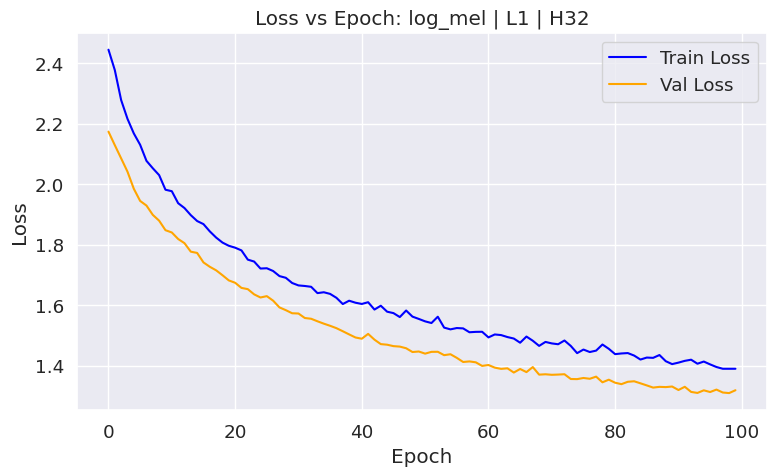

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

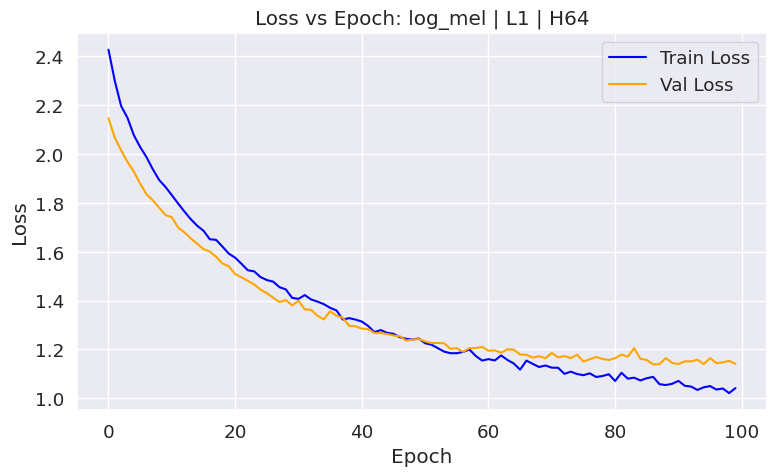

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

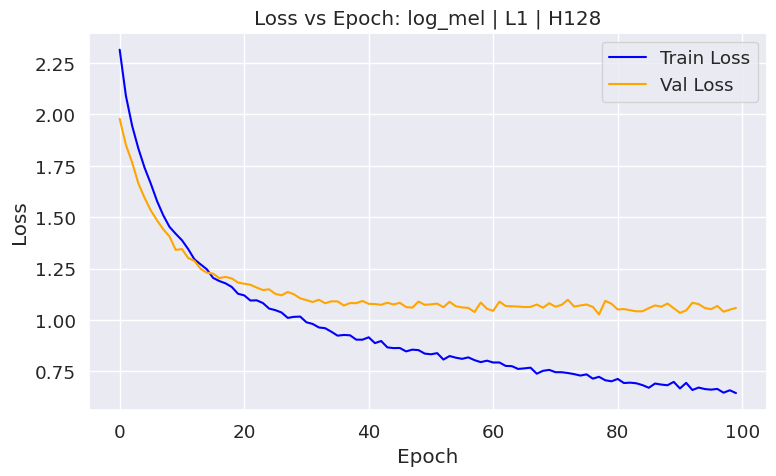

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

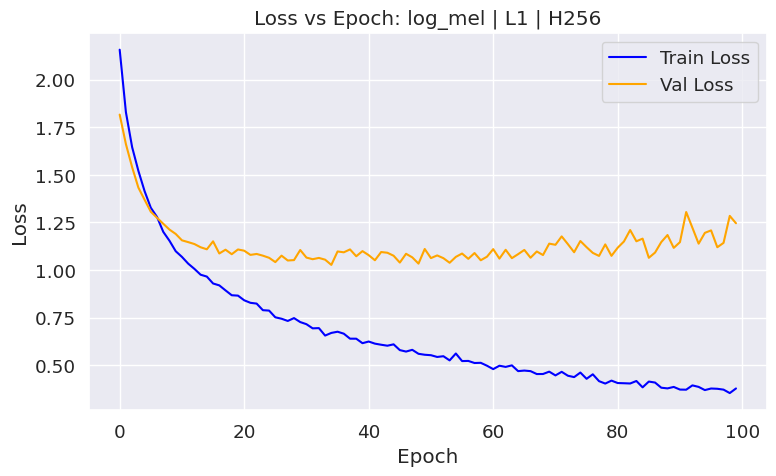

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

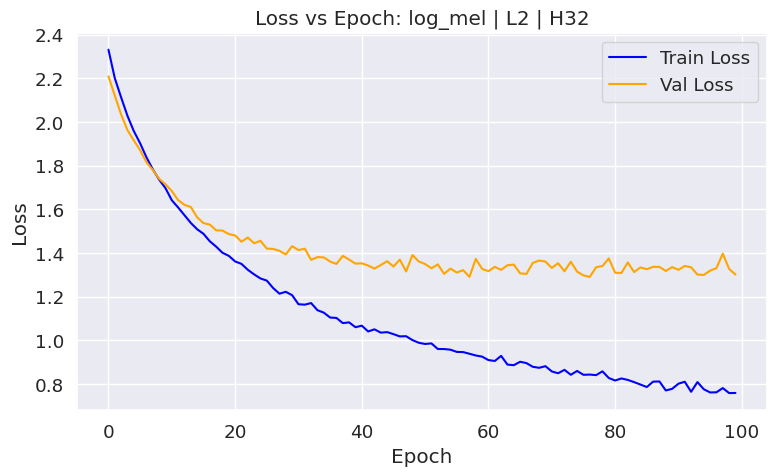

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

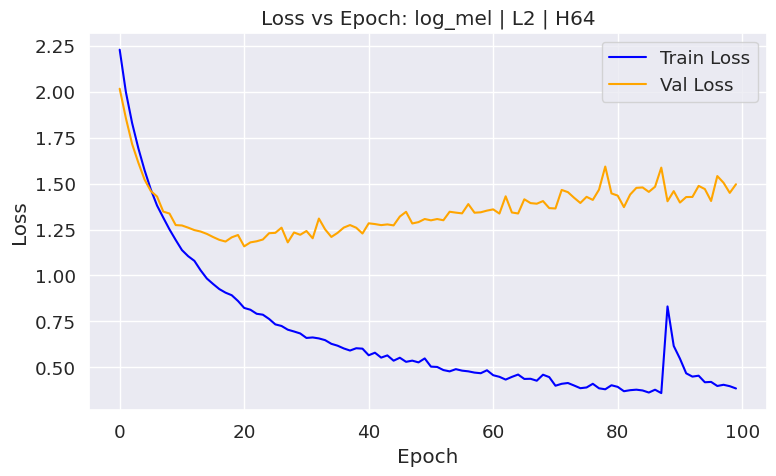

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

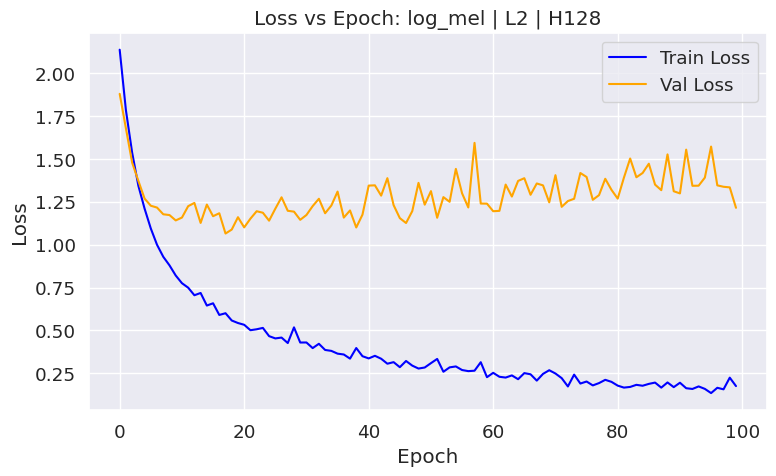

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

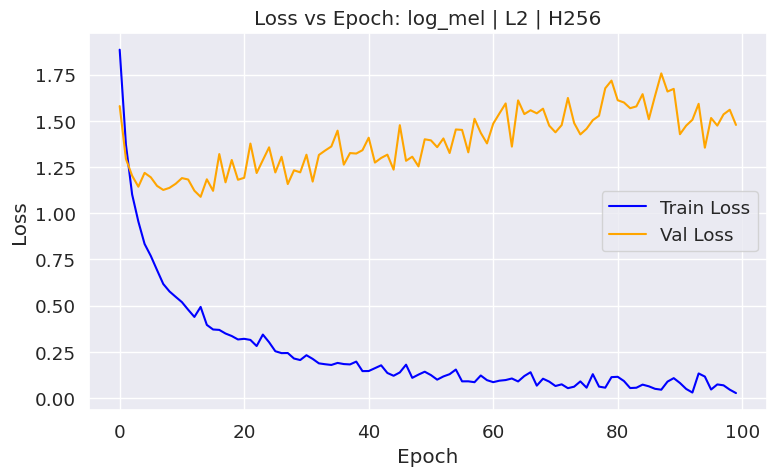

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

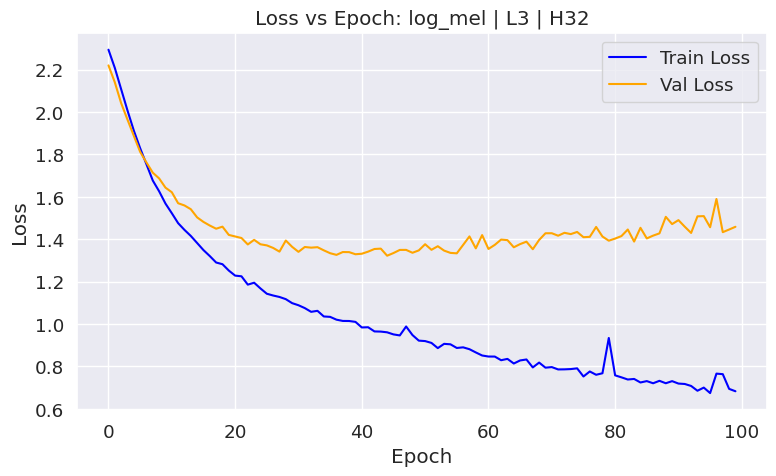

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

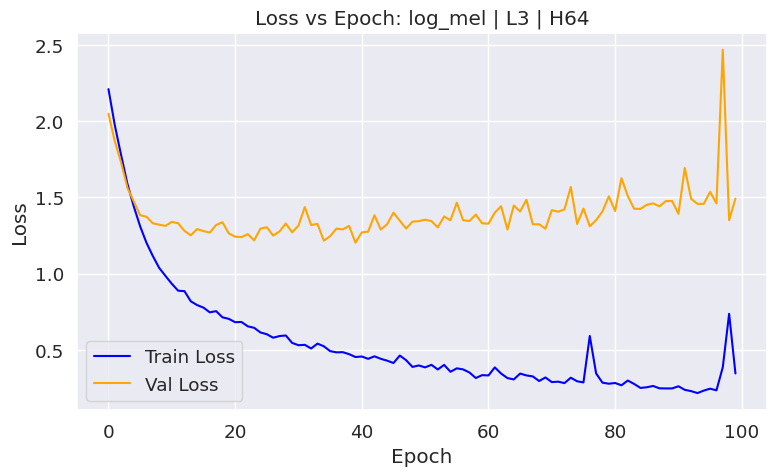

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

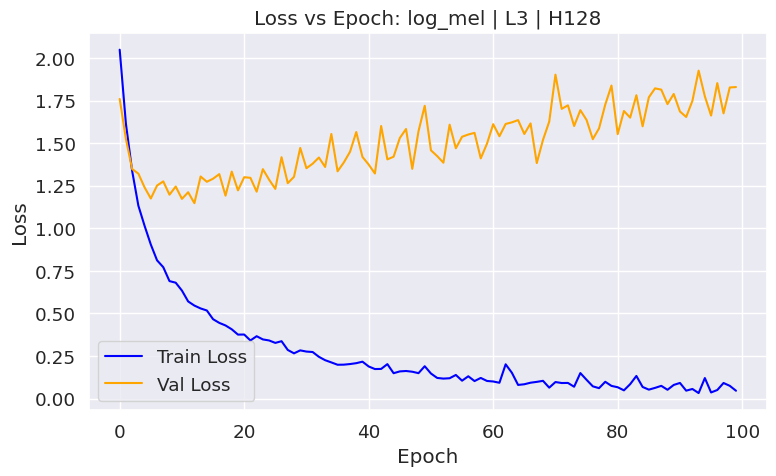

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

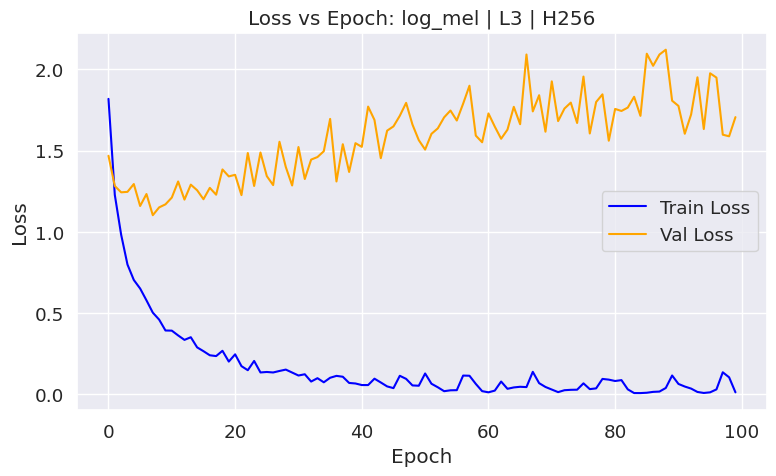

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

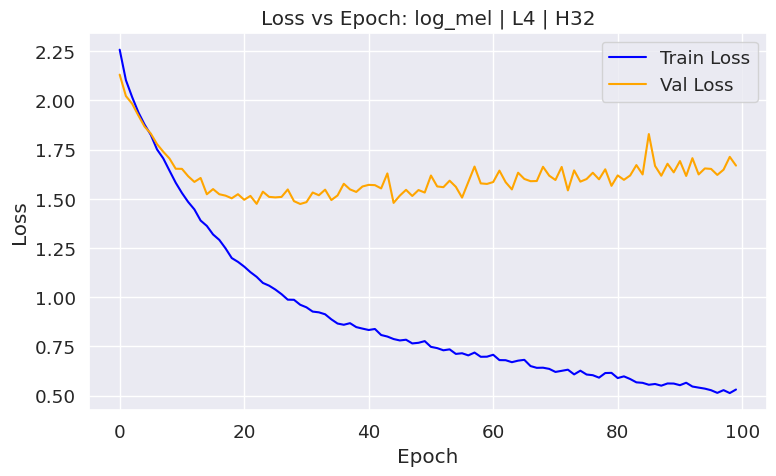

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

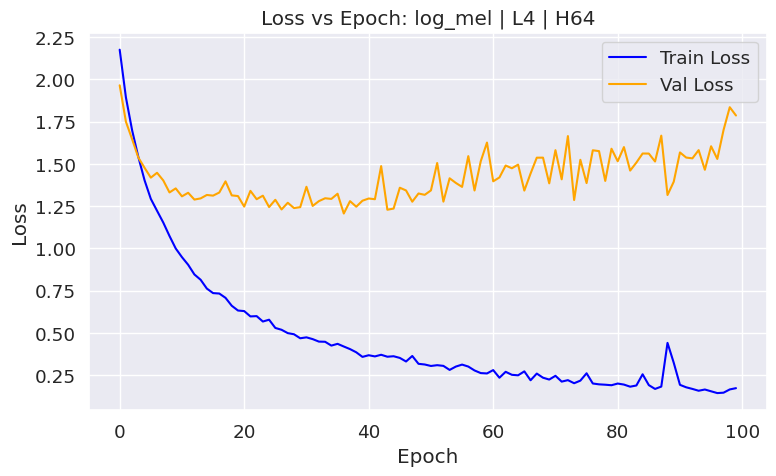

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

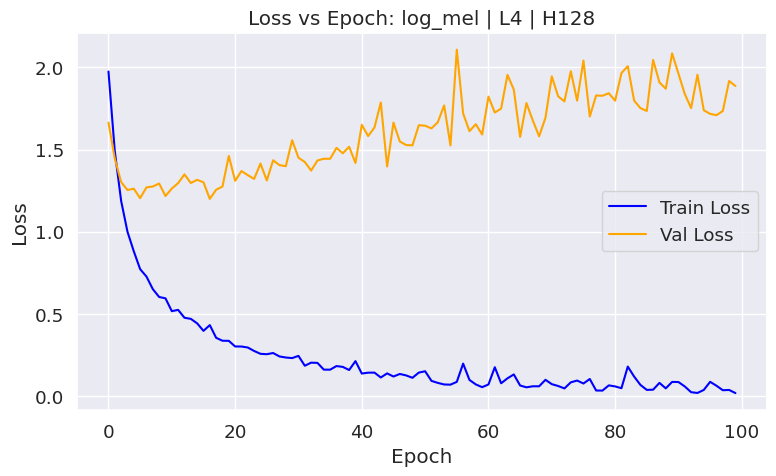

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

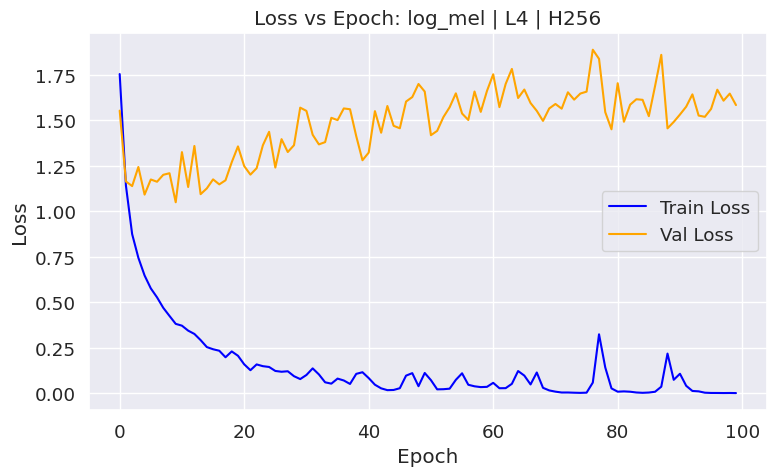

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

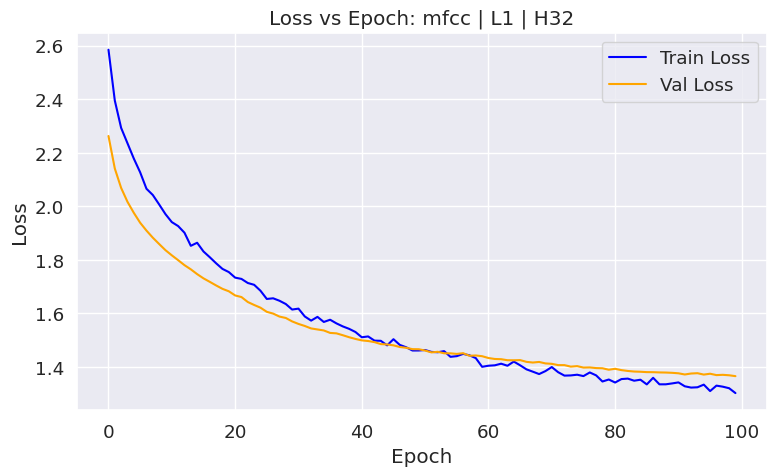

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

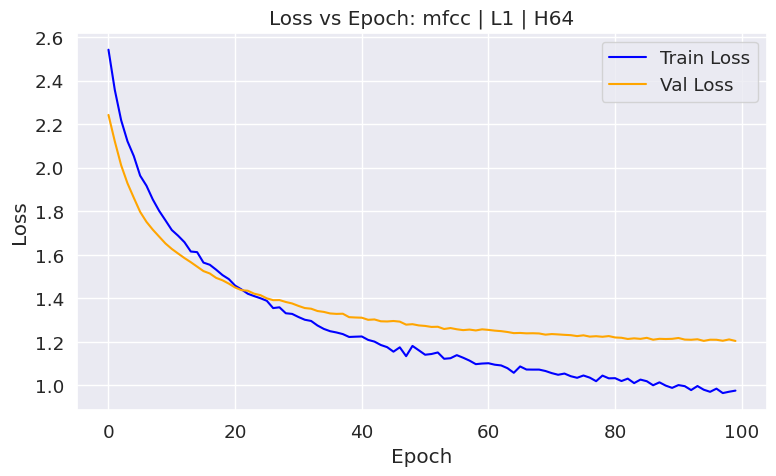

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

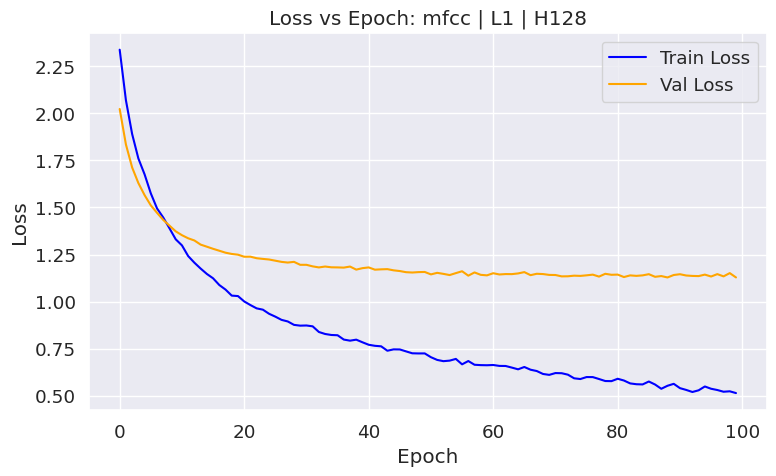

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

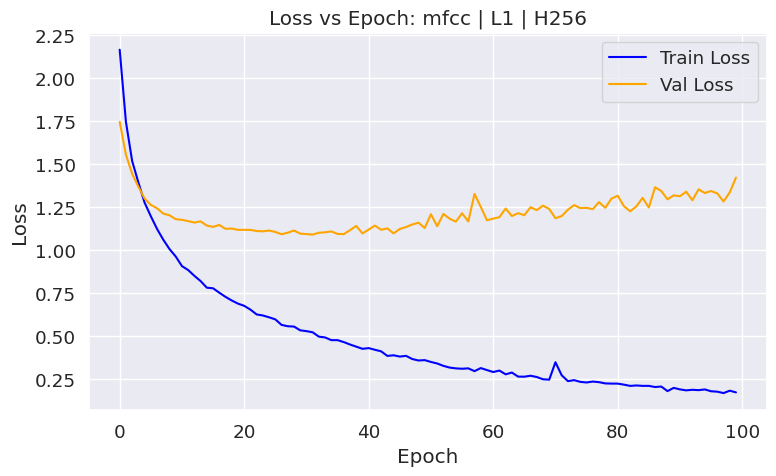

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

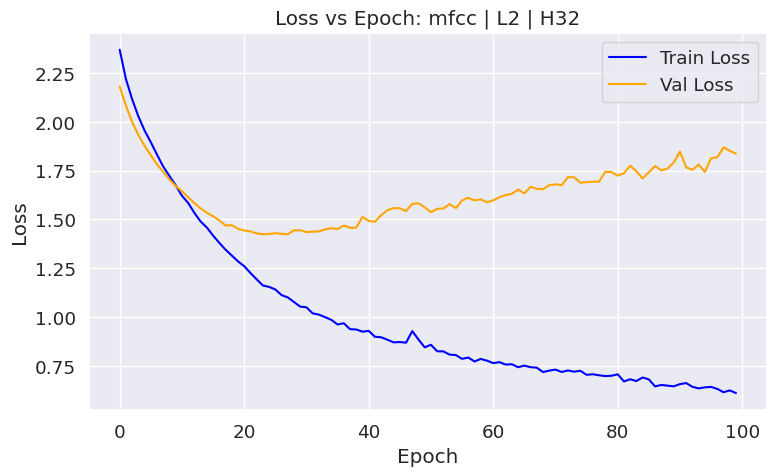

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

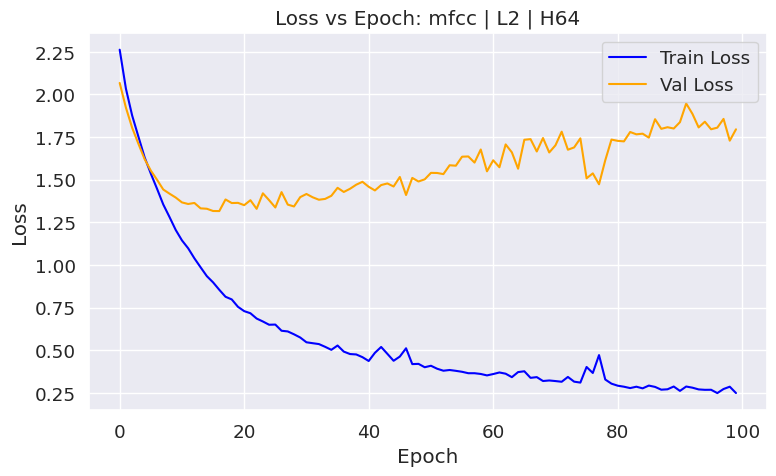

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

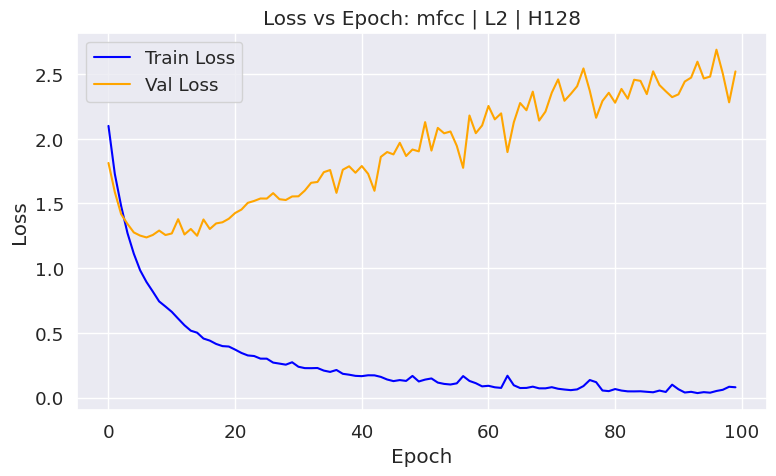

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

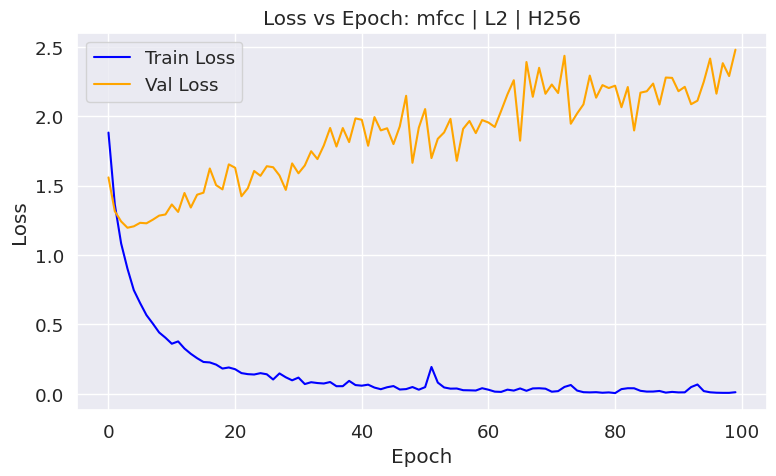

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

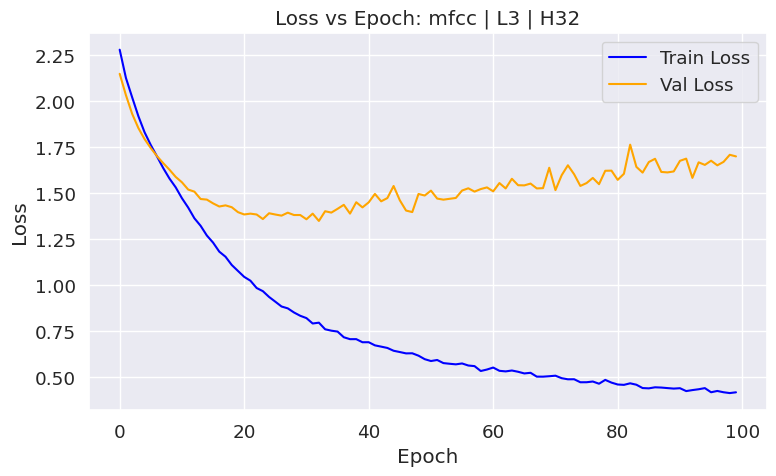

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

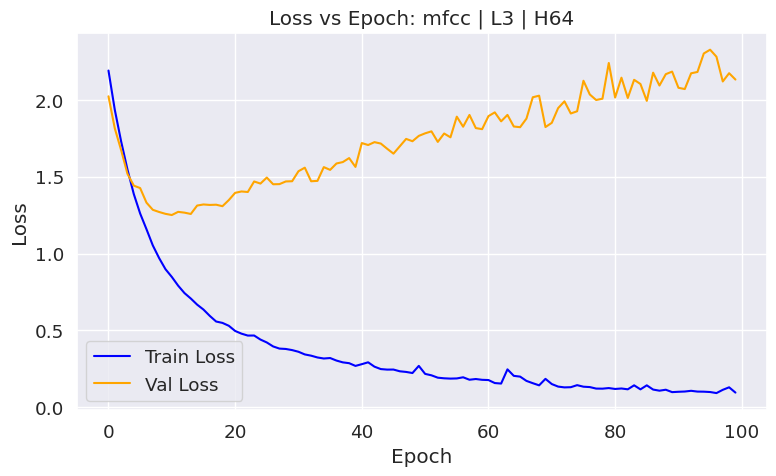

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

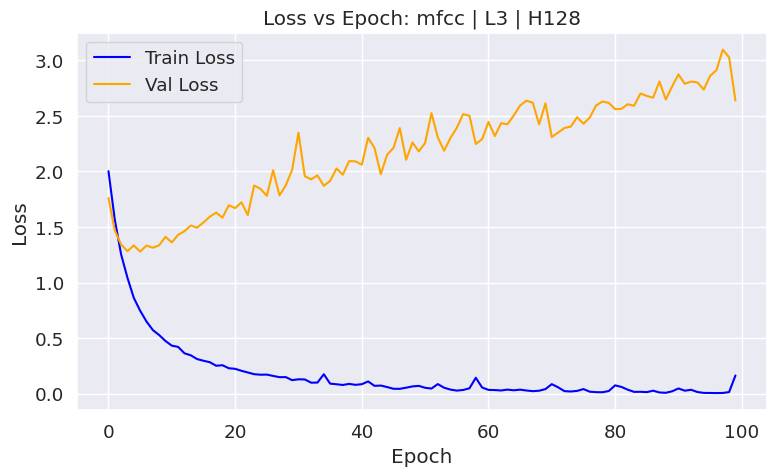

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

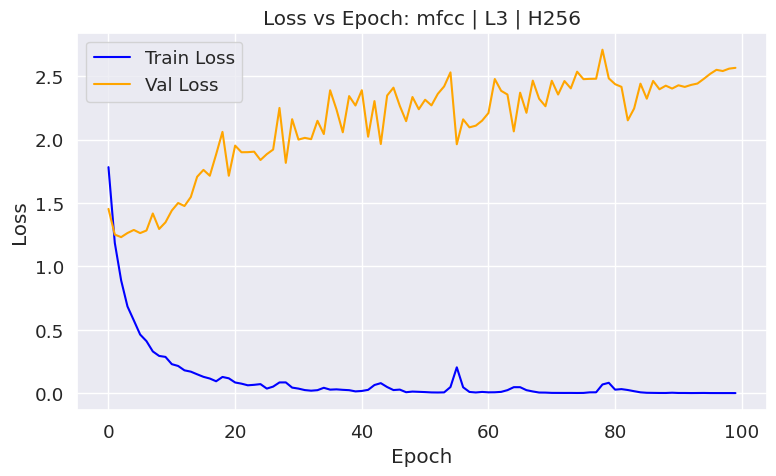

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

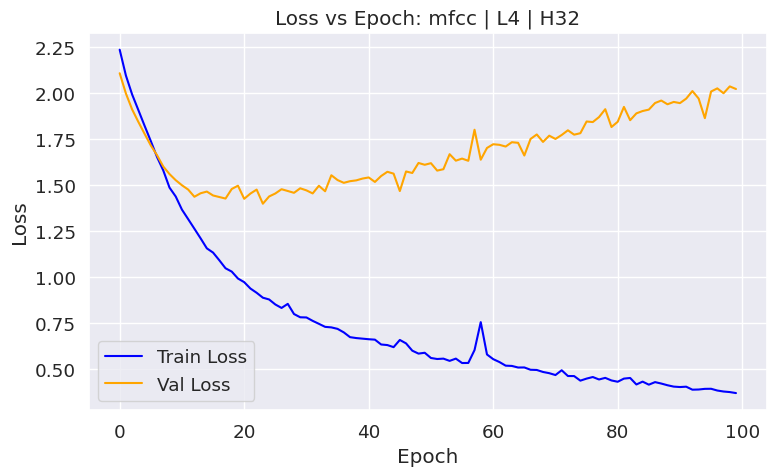

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

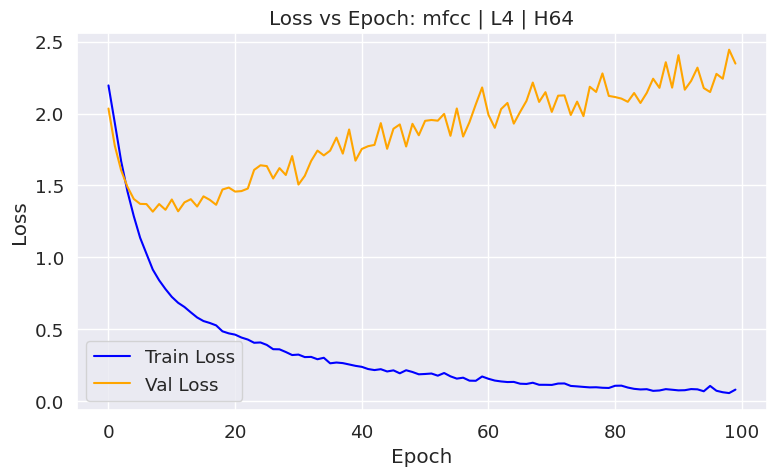

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

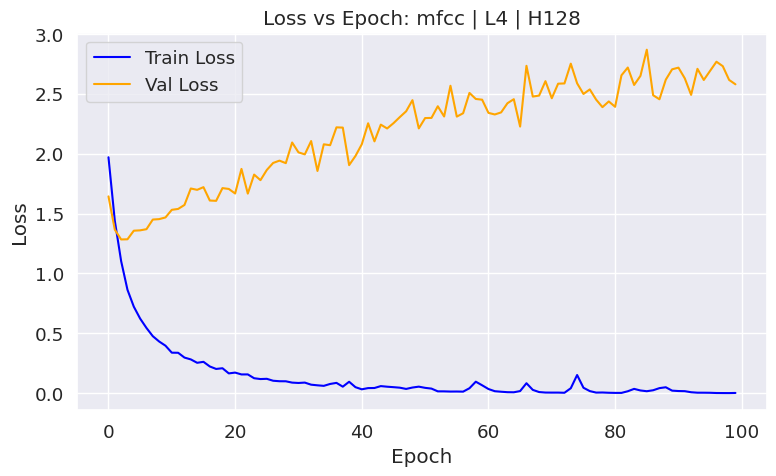

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

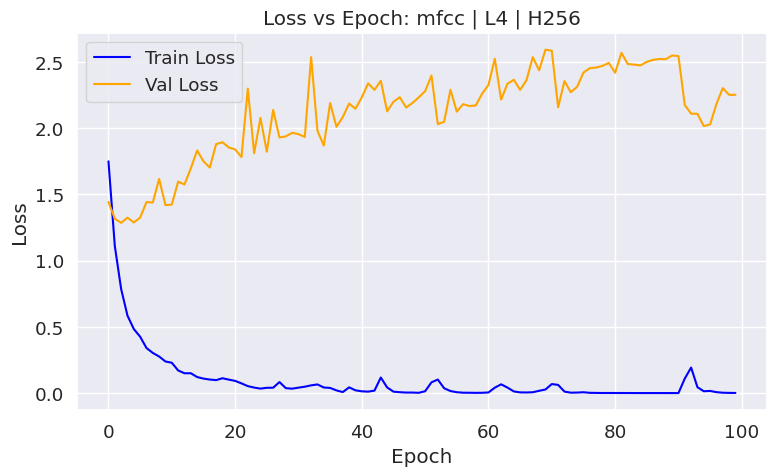

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

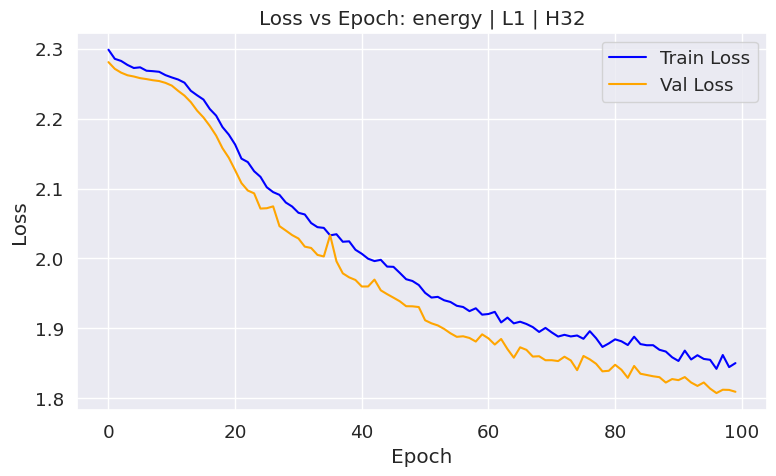

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

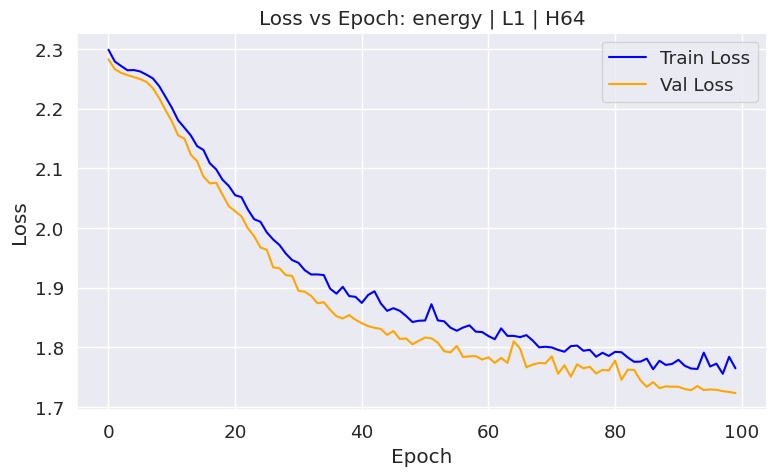

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

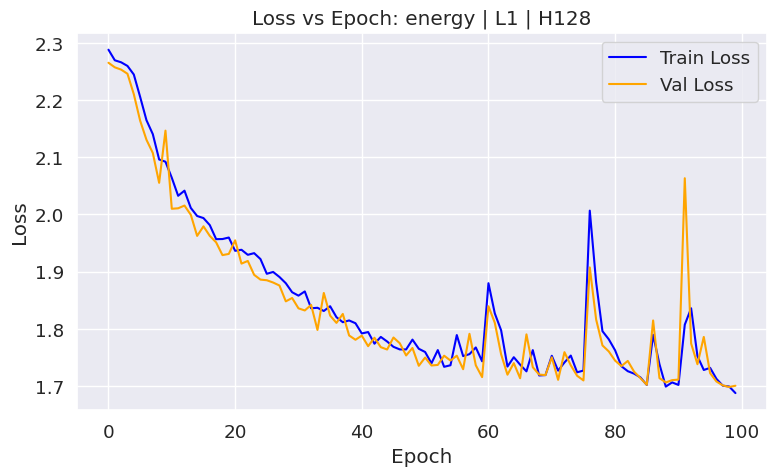

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

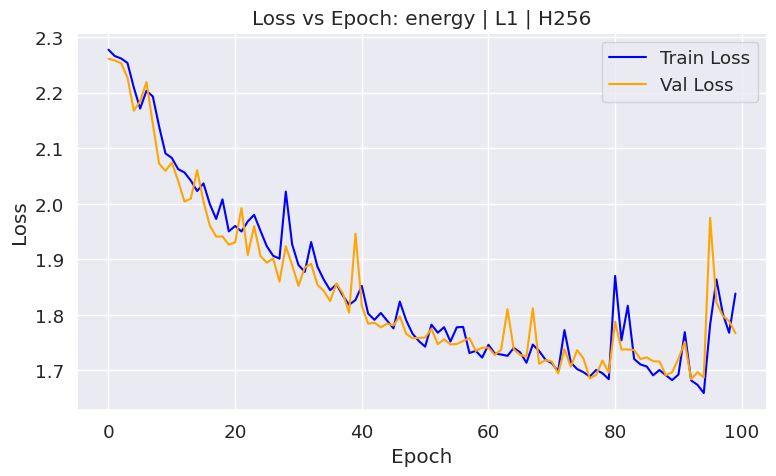

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

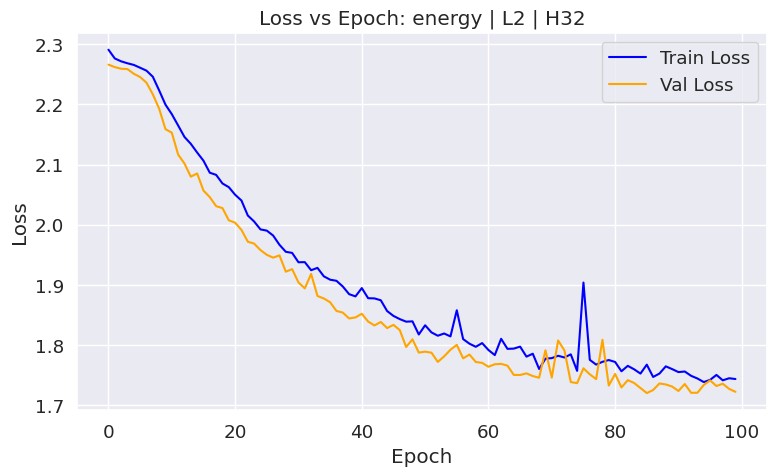

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

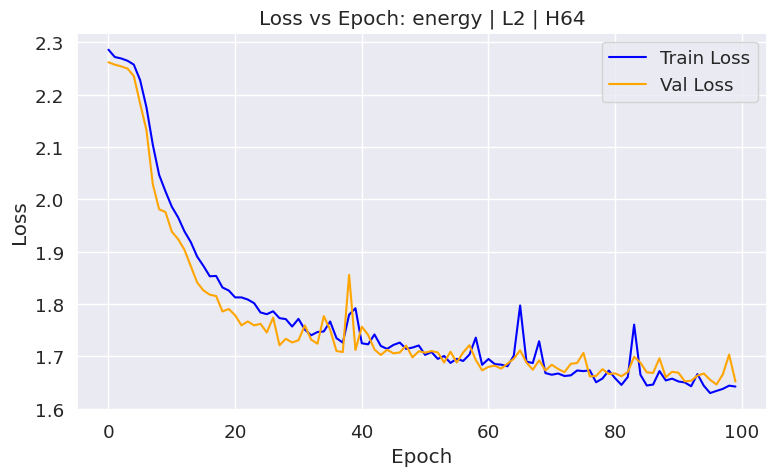

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

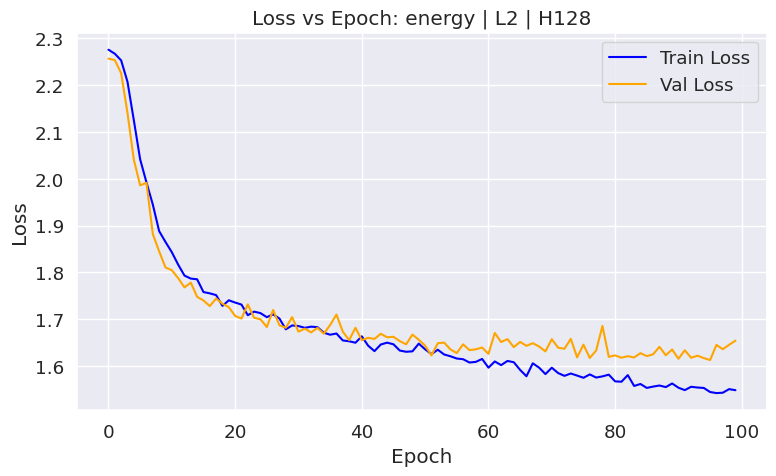

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

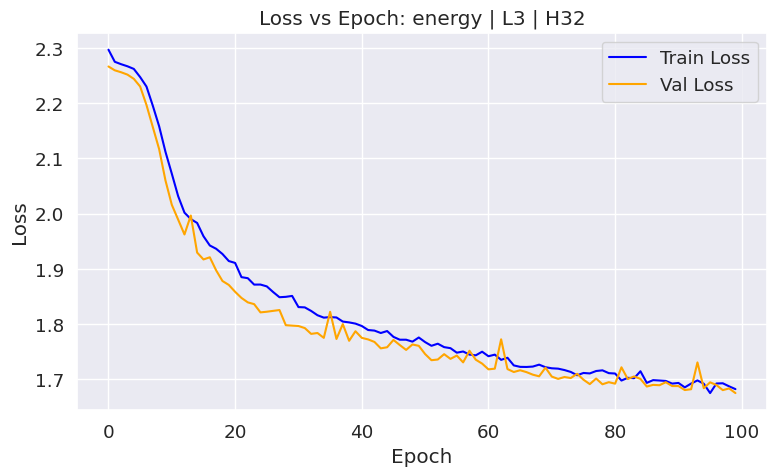

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

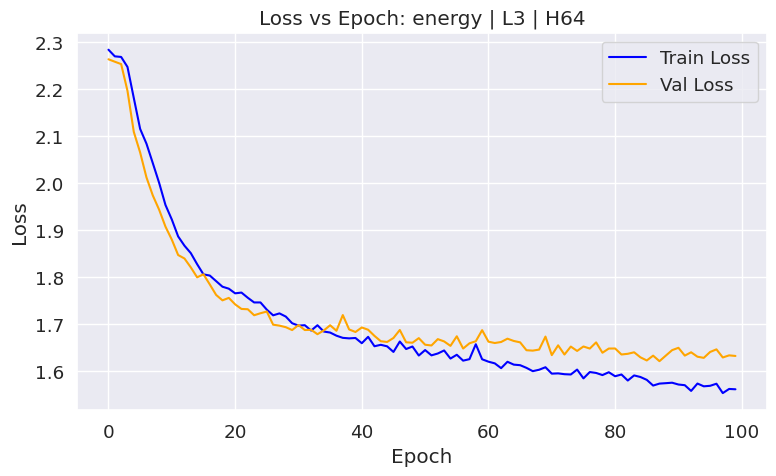

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

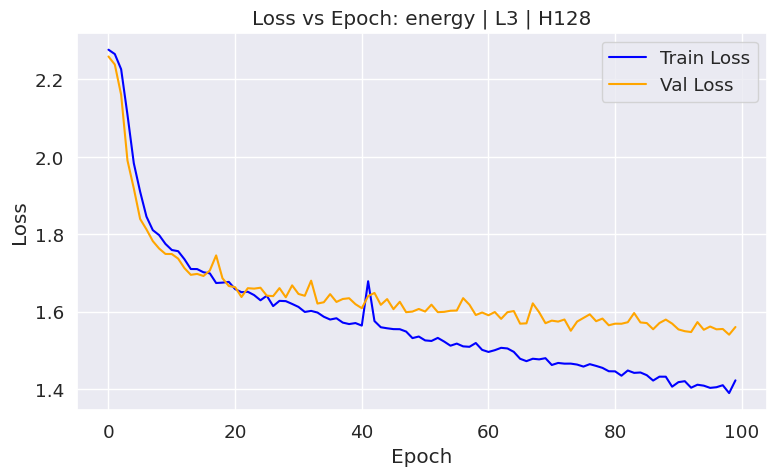

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

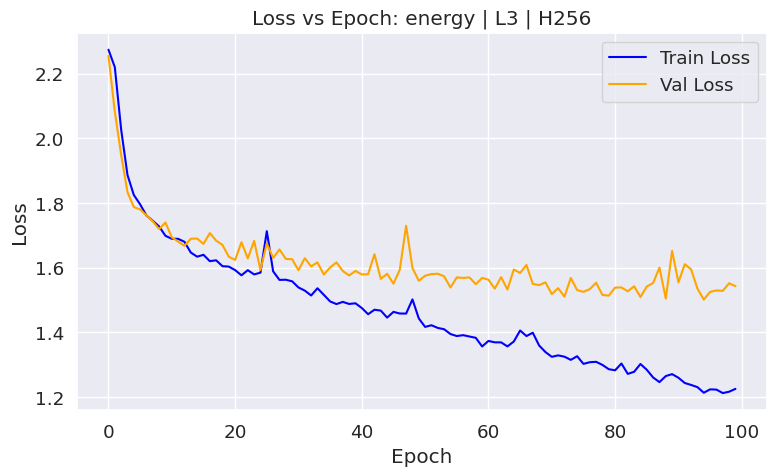

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

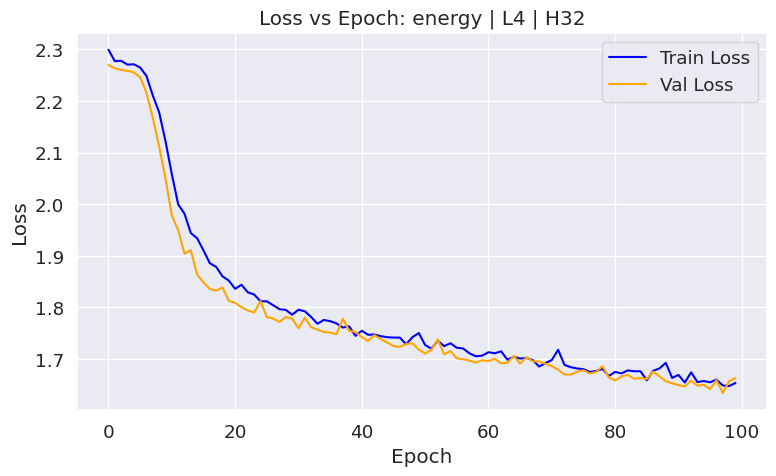

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

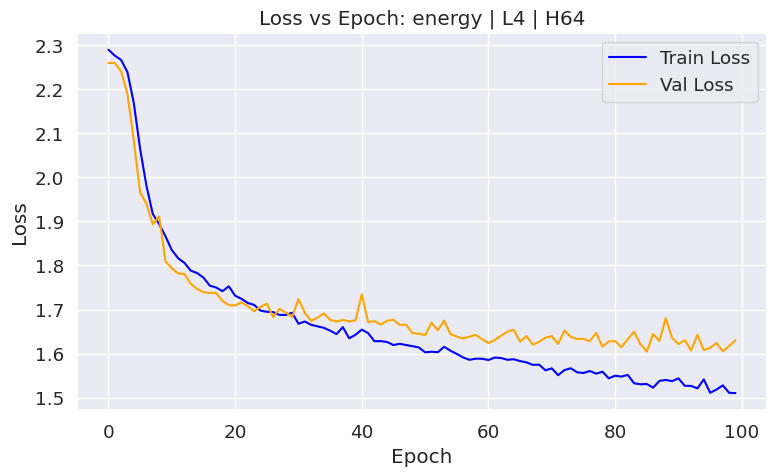

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

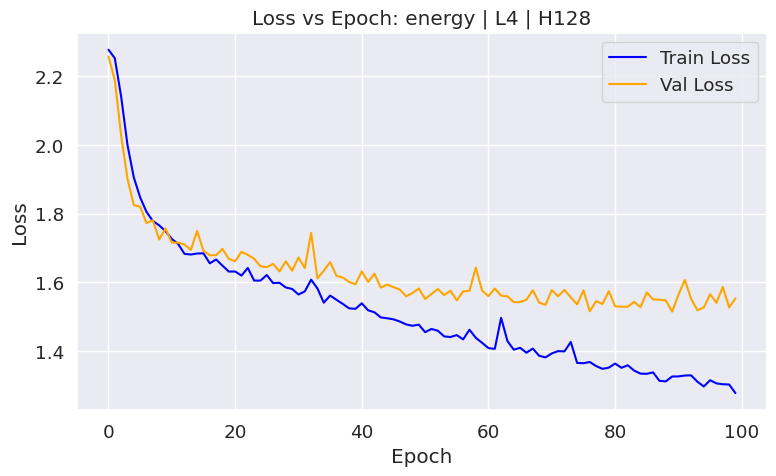

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

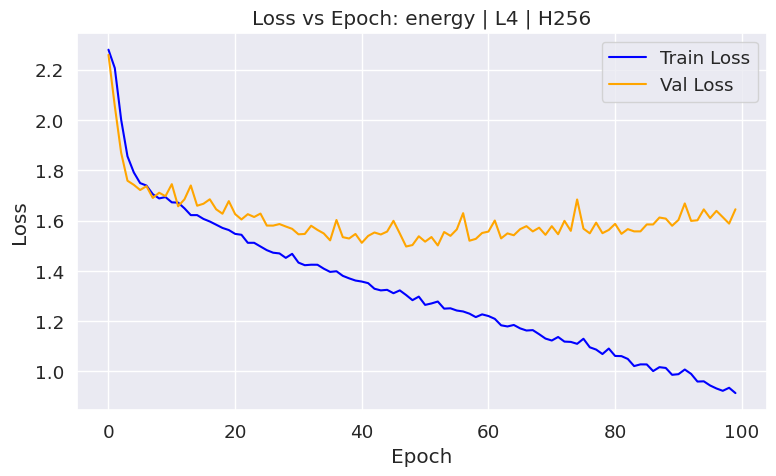

In [159]:
df = pd.DataFrame(results_rnn)
df['Config'] = df.apply(lambda row: f"{row['Feature']} | L{row['Num_Layers']} | H{row['Hidden_Size']}", axis=1)

unique_configs = df['Config'].unique()

for config in unique_configs:
    df_config = df[df['Config'] == config]

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_config, x='Epoch', y='Train_Loss', label='Train Loss', color='blue')
    sns.lineplot(data=df_config, x='Epoch', y='Val_Loss', label='Val Loss', color='orange')

    plt.title(f"Loss vs Epoch: {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


=== Feature: log_mel, Layers: 1, Hidden size: 256 ===

Test Loss: 1.2421
Test Accuracy: 66.00%
F1 Score: 0.6964


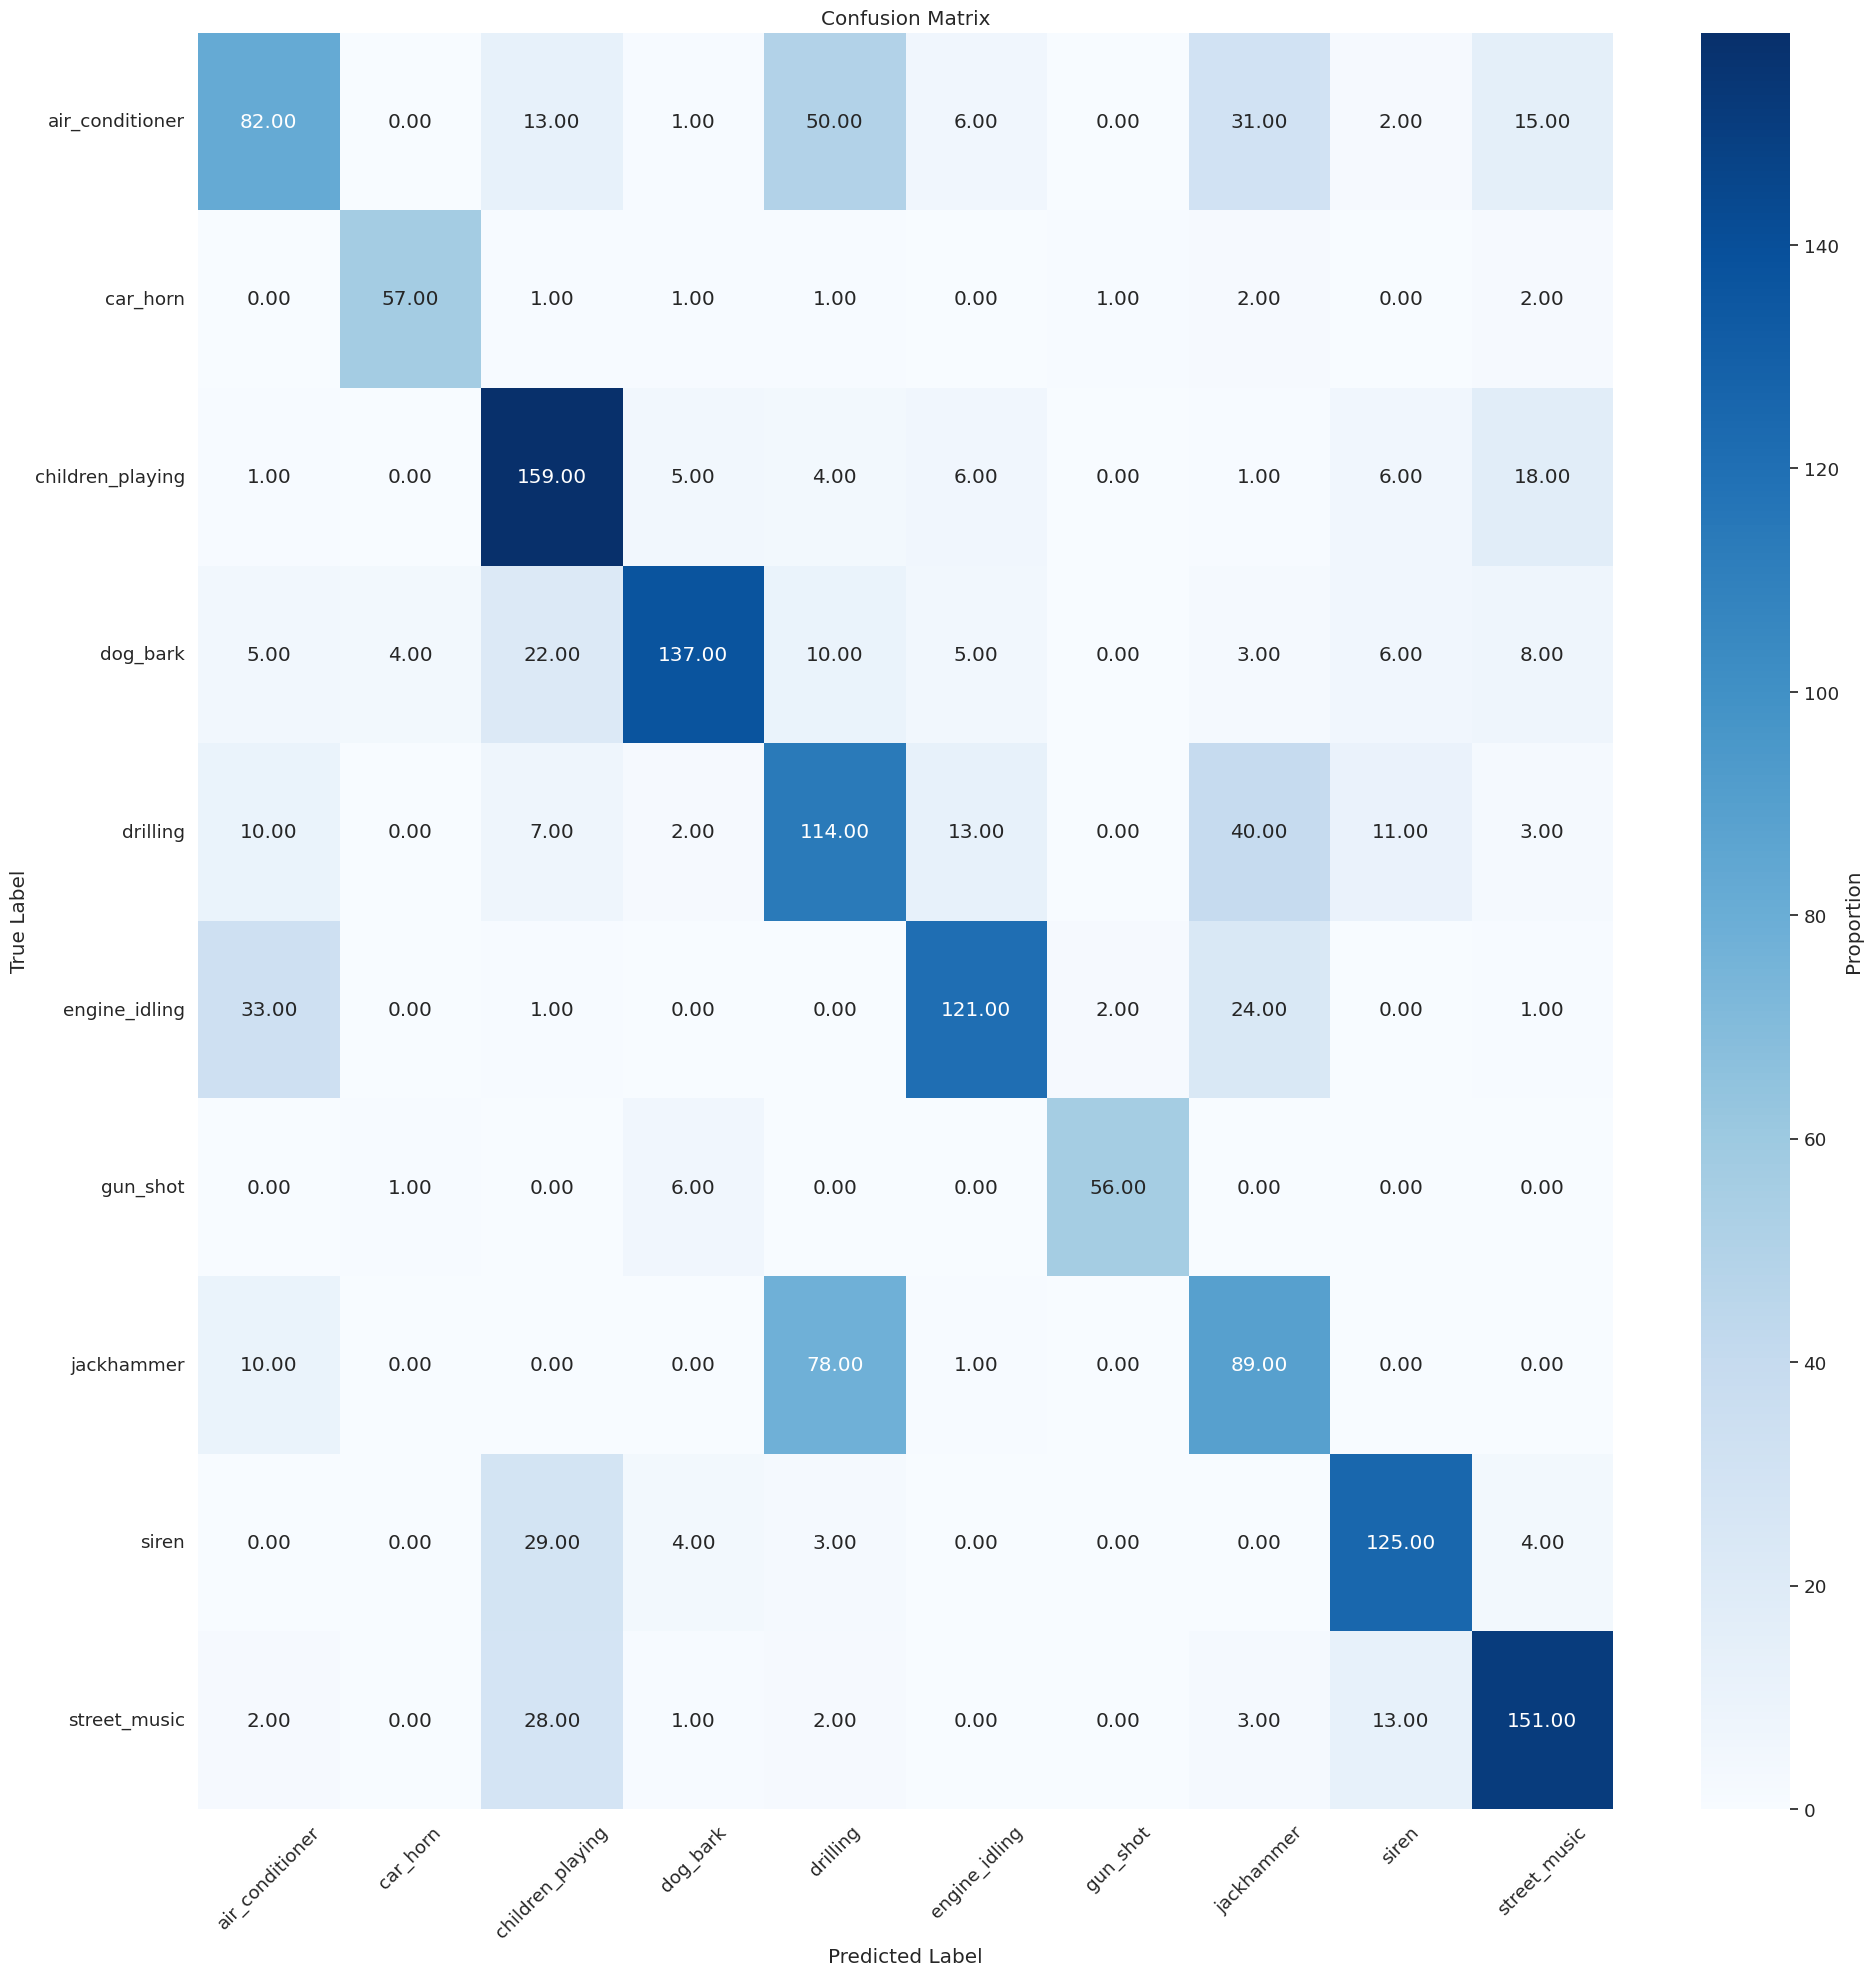

In [164]:
from torch.utils.data import TensorDataset, DataLoader

print(f"\n=== Feature: log_mel, Layers: 1, Hidden size: 256 ===")
X_test_np = np.stack([x['log_mel'] for x in test_features])
X_test_np = np.transpose(X_test_np, (0, 2, 1))
X_test = torch.tensor(X_test_np, dtype=torch.float32)

y_test = torch.tensor(test_labels_idx, dtype=torch.long)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size = 60, shuffle = False)  

model = SoundClassifierRNN(
        input_size = X_test.shape[2],
        hidden_size = 256,
        num_layers = 1
        ).to(device)
model_filename = f"saved_models/model_log_mel_L1_H256.pth"
model.load_state_dict(torch.load(model_filename))

model.eval()
test_loss = 0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
avg_test_loss = test_loss / total
test_accuracy = 100. * correct / total
print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")       
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
labels = list(class_to_index.keys())
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


=== Feature: mfcc, Layers: 1, Hidden size: 128 ===

Test Loss: 1.3631
Test Accuracy: 59.41%
F1 Score: 0.6002


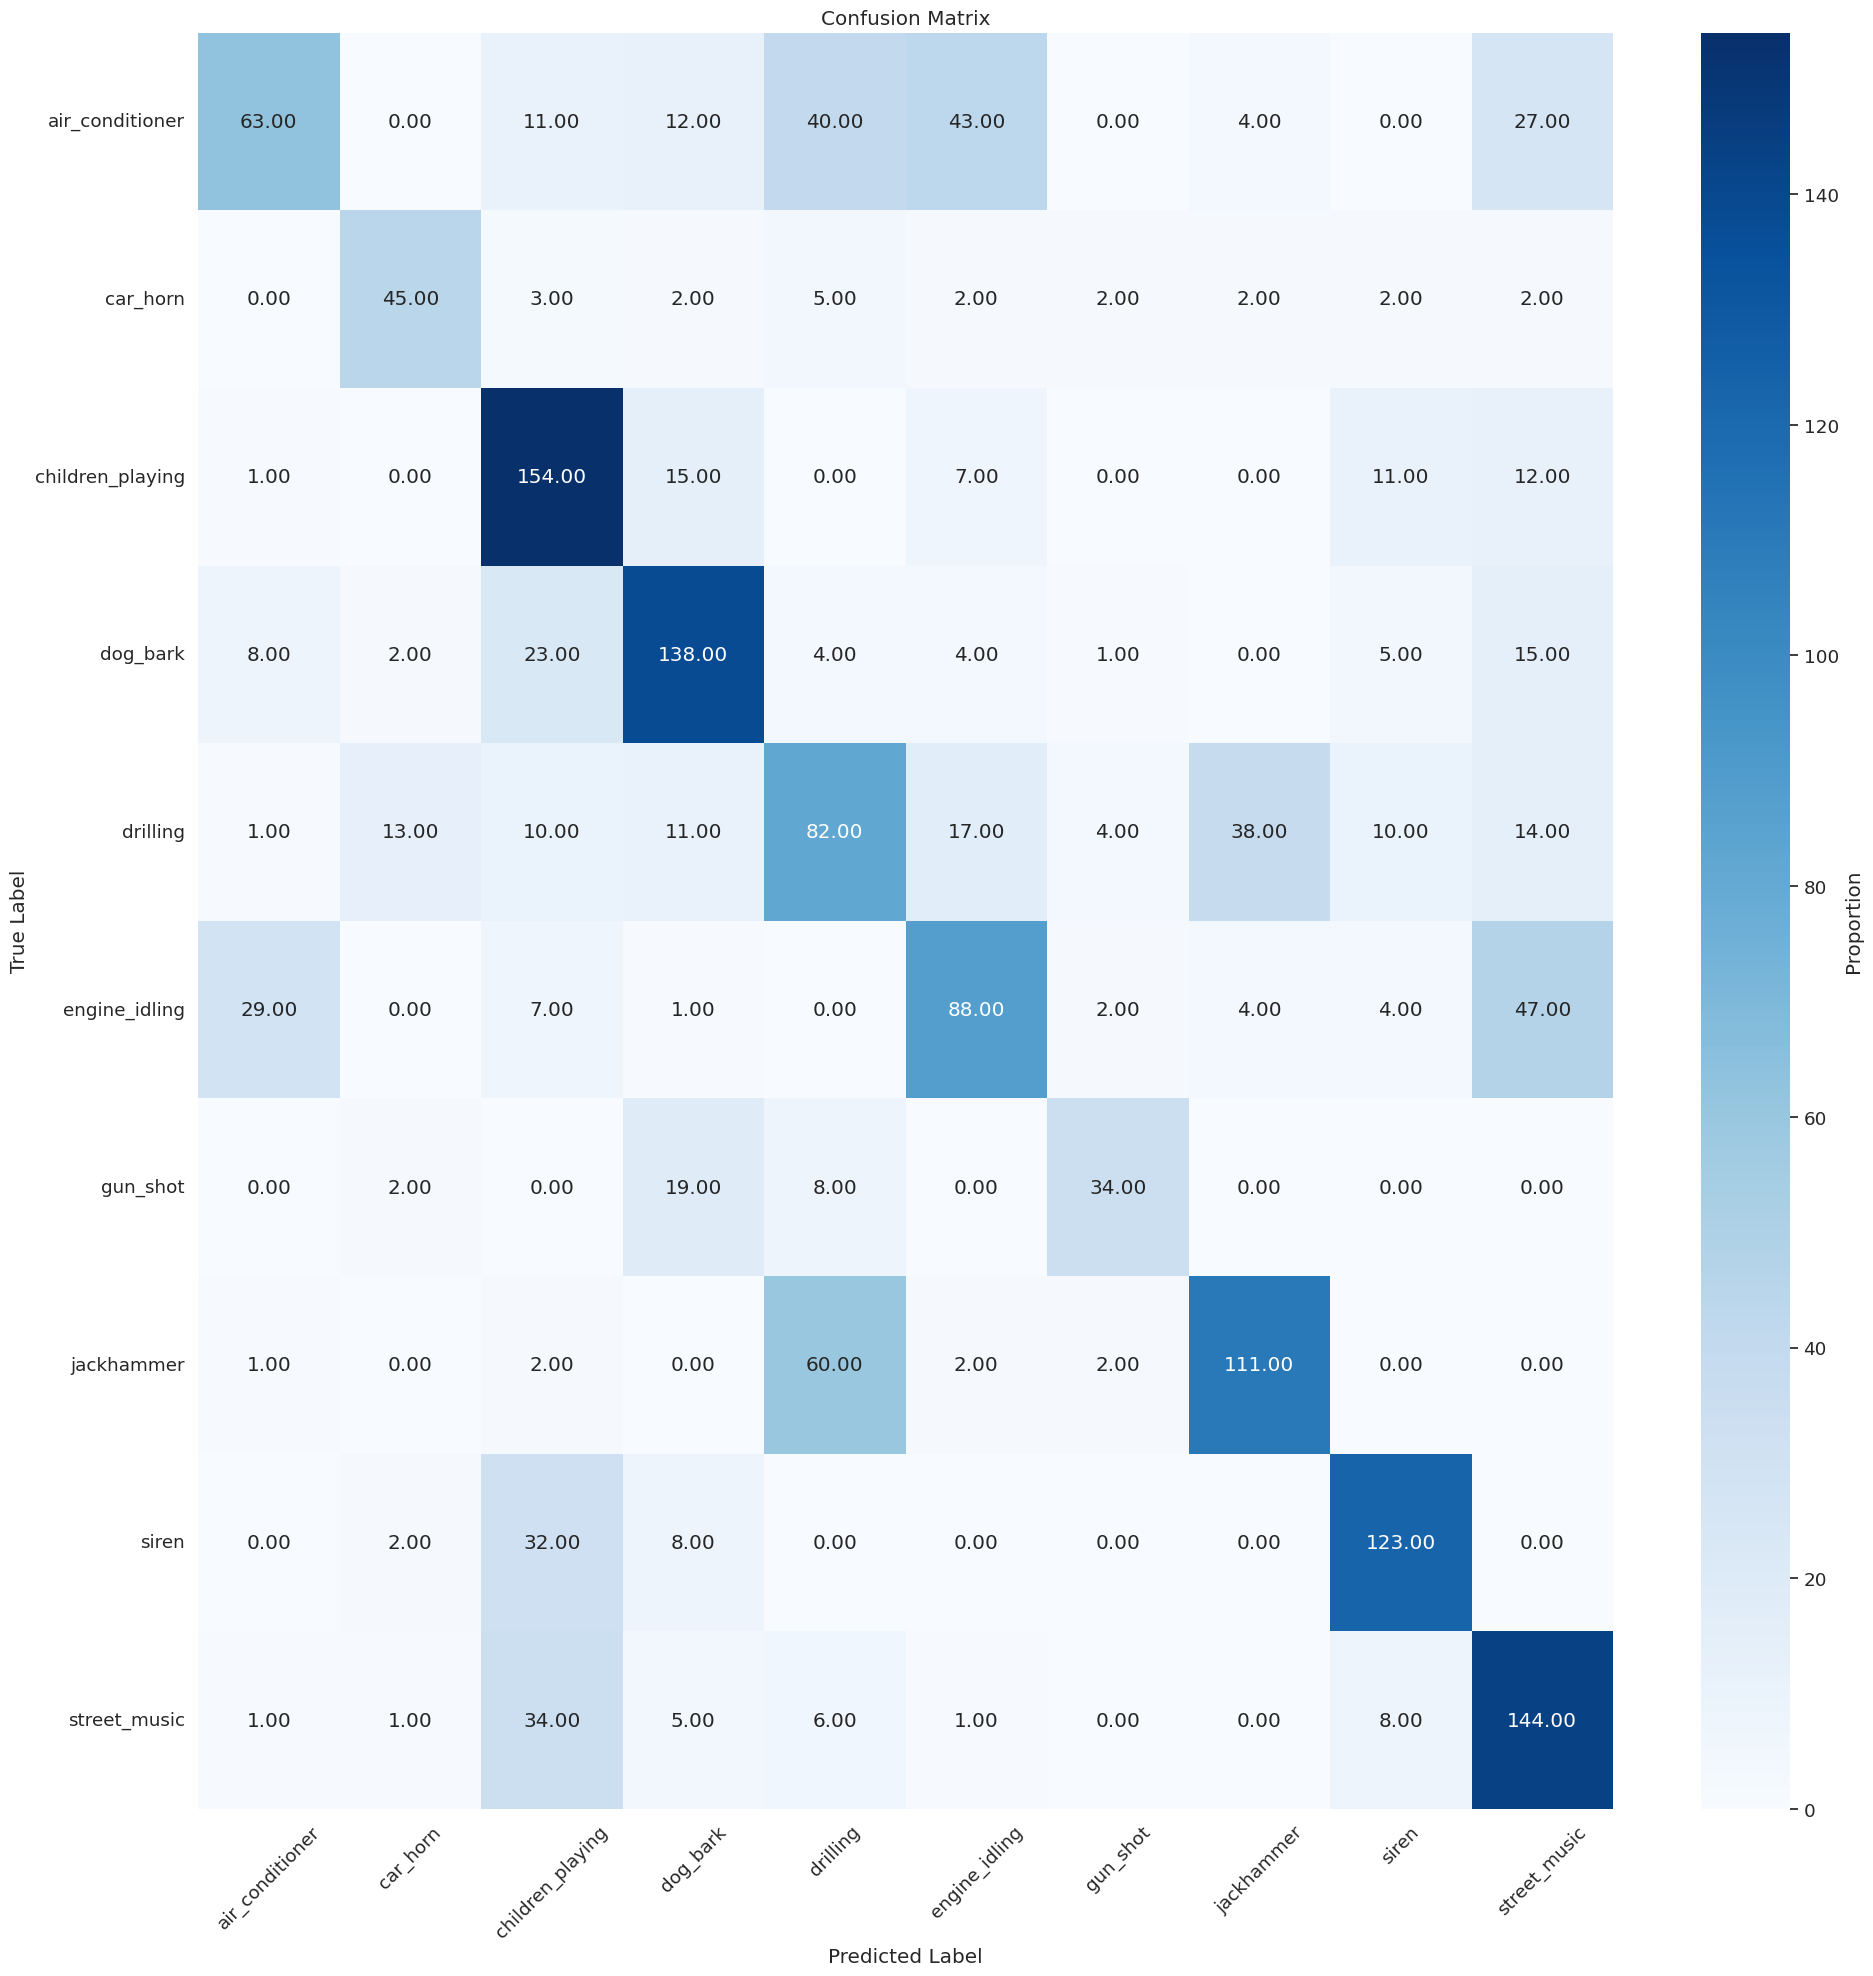

In [169]:
from torch.utils.data import TensorDataset, DataLoader

print(f"\n=== Feature: mfcc, Layers: 1, Hidden size: 128 ===")
X_test_np = np.stack([x['mfcc'] for x in test_features])
X_test_np = np.transpose(X_test_np, (0, 2, 1))
X_test = torch.tensor(X_test_np, dtype=torch.float32)

y_test = torch.tensor(test_labels_idx, dtype=torch.long)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size = 60, shuffle = False)  

model = SoundClassifierRNN(
        input_size = X_test.shape[2],
        hidden_size = 128,
        num_layers = 1
        ).to(device)
model_filename = f"saved_models/model_mfcc_L1_H128.pth"
model.load_state_dict(torch.load(model_filename))

model.eval()
test_loss = 0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
avg_test_loss = test_loss / total
test_accuracy = 100. * correct / total
print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")       
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
labels = list(class_to_index.keys())
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


=== Feature: energy, Layers: 2, Hidden size: 256 ===

Test Loss: 1.5555
Test Accuracy: 49.43%
F1 Score: 0.5071


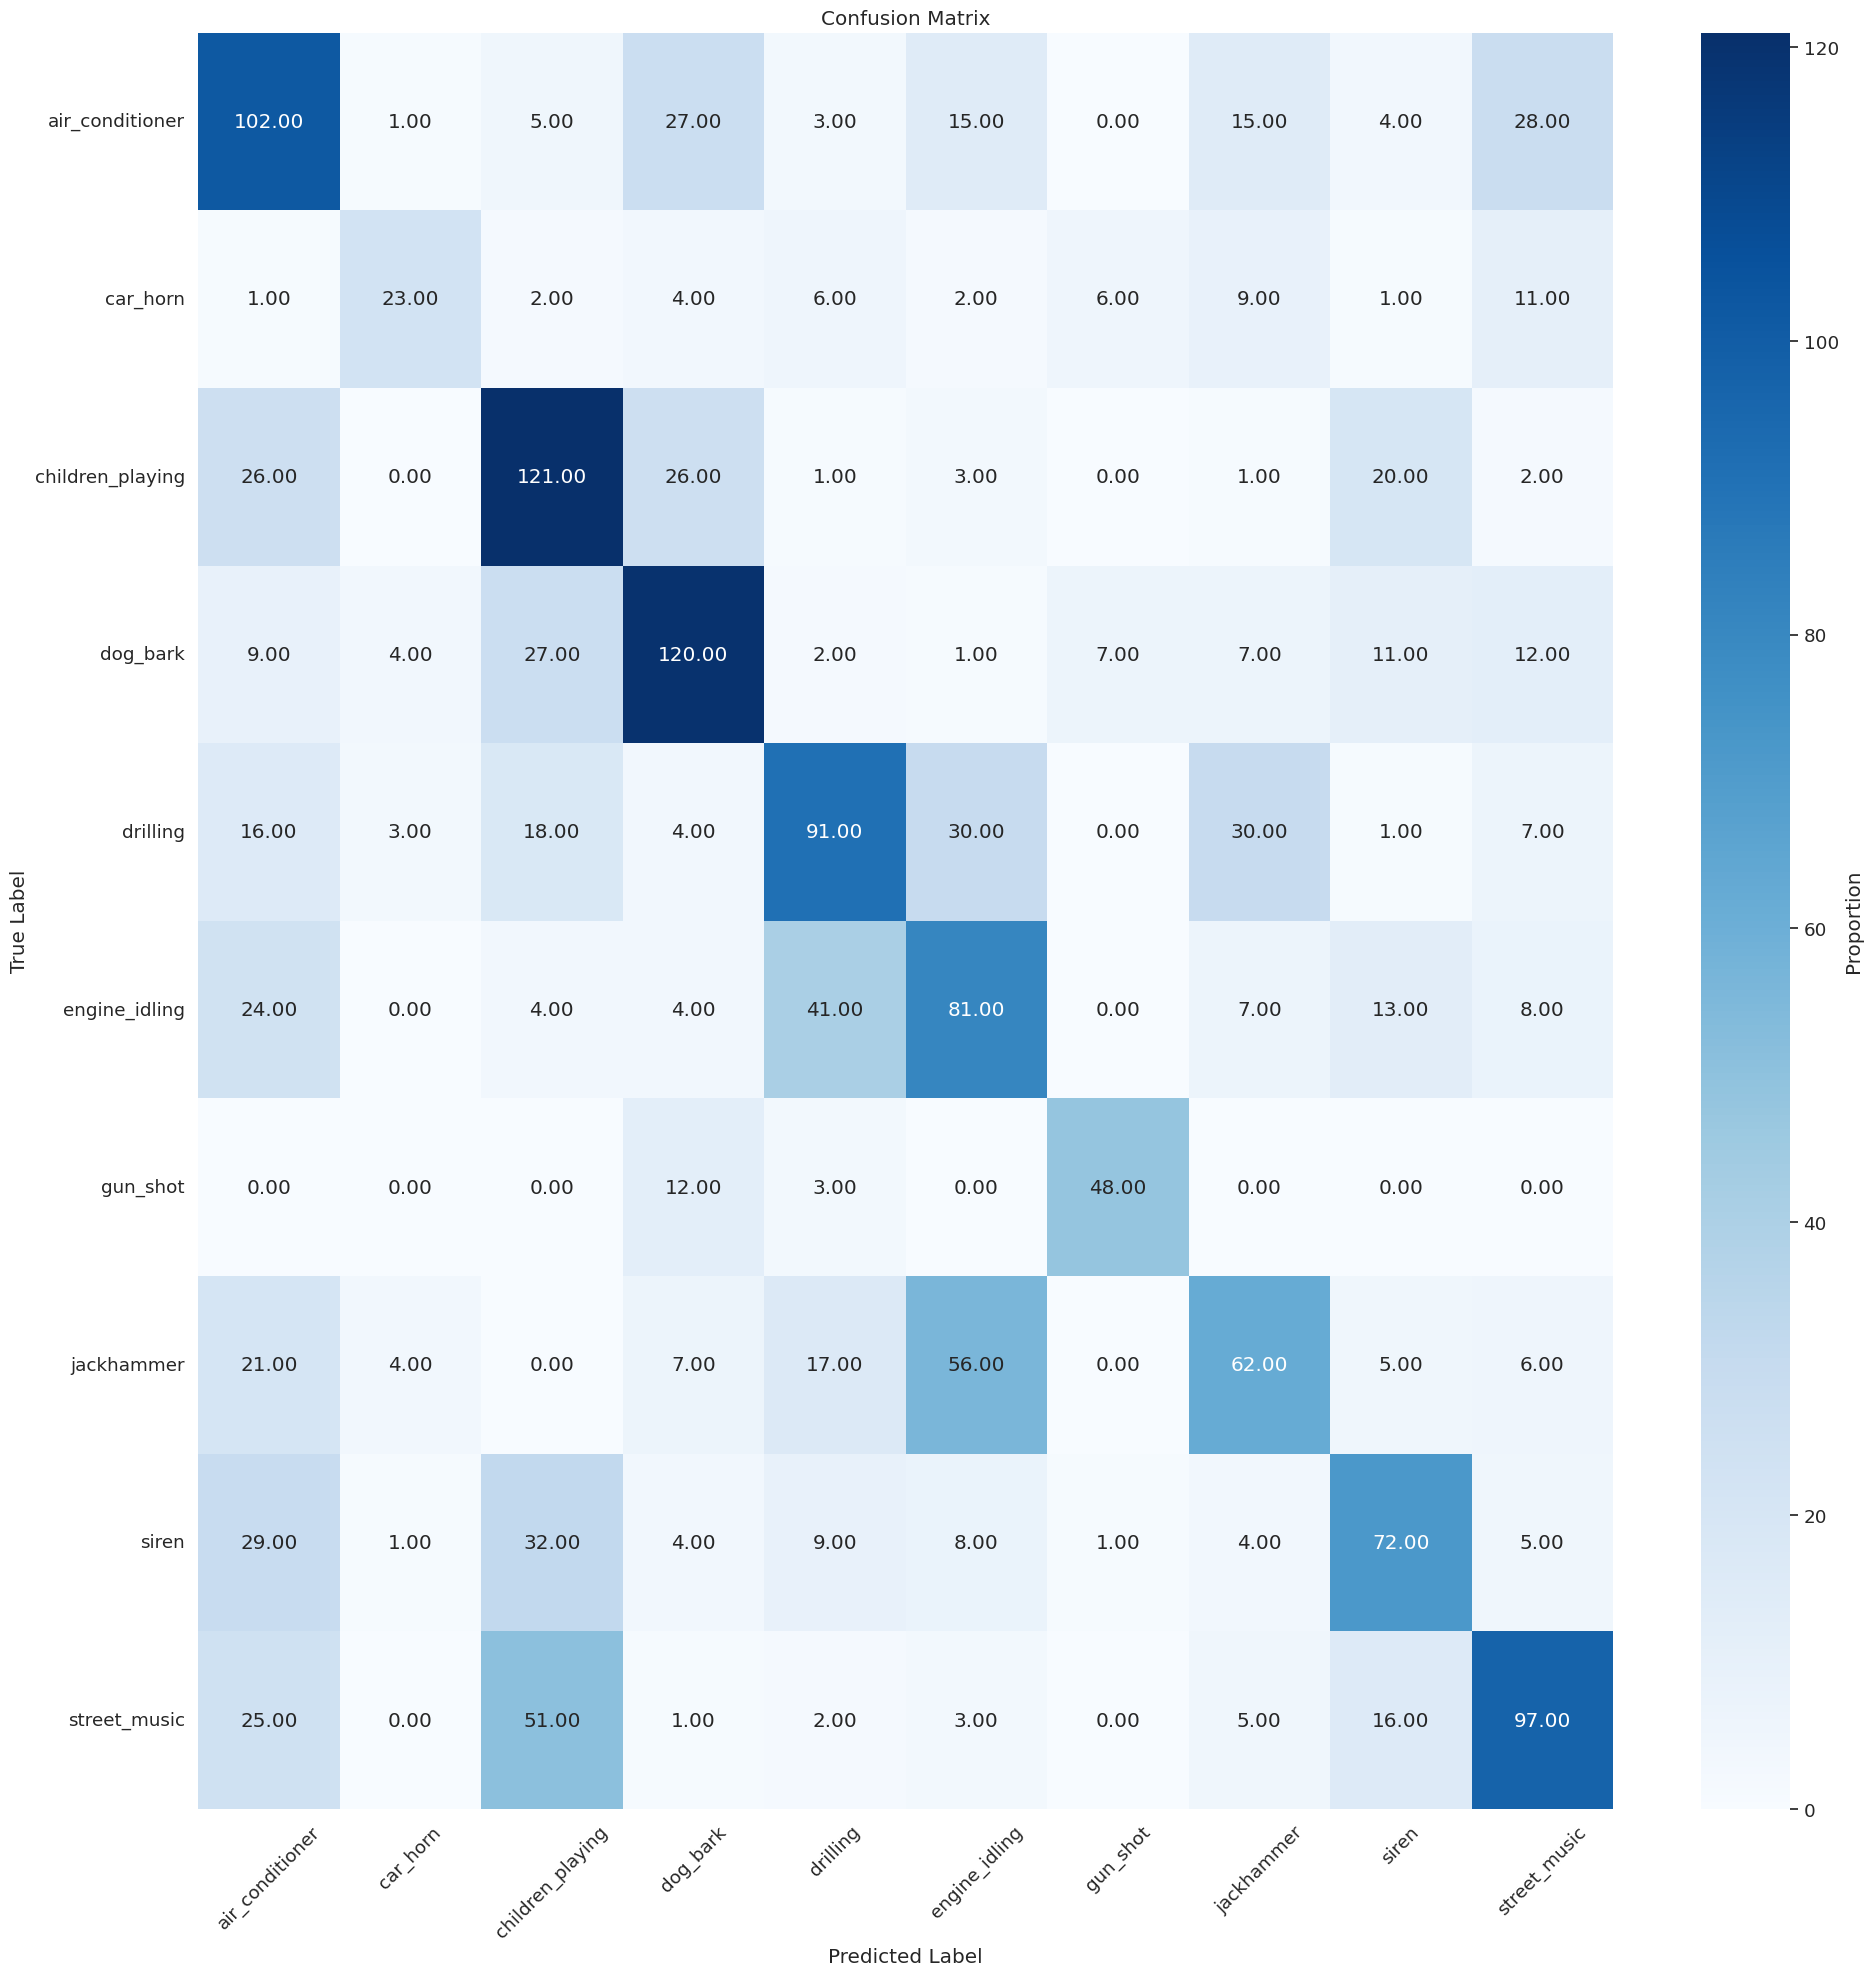

In [166]:
from torch.utils.data import TensorDataset, DataLoader

print(f"\n=== Feature: energy, Layers: 3, Hidden size: 128 ===")
X_test_np = np.stack([x['energy'] for x in test_features])
X_test_np = np.transpose(X_test_np, (0, 2, 1))
X_test = torch.tensor(X_test_np, dtype=torch.float32)

y_test = torch.tensor(test_labels_idx, dtype=torch.long)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size = 60, shuffle = False)  

model = SoundClassifierRNN(
        input_size = X_test.shape[2],
        hidden_size = 128,
        num_layers = 3
        ).to(device)
model_filename = f"saved_models/model_energy_L3_H128.pth"
model.load_state_dict(torch.load(model_filename))

model.eval()
test_loss = 0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
avg_test_loss = test_loss / total
test_accuracy = 100. * correct / total
print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")       
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
labels = list(class_to_index.keys())
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [170]:
class SoundClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional = True, num_classes = 10):
        super(SoundClassifierLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          bidirectional = bidirectional,
                          batch_first = True)
        
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)
        self.dropout = nn.Dropout(p = 0.6)
        
    def forward(self, x):
        # x: [batch_size, time_steps, input_size]
        out, _ = self.lstm(x)           # out: [batch_size, time_steps, hidden_size]
        out, _ = out.max(dim=1)        # use element_wise max for all hidden states (e.g. like what happem in sentiment classification)
        out = self.dropout(out)
        out = self.fc(out)             # out: [batch_size, num_classes]
        return out

In [171]:
num_layers_list = [1, 2, 3, 4]
hidden_sizes_list = [32, 64, 128, 256]
features = [
    "log_mel",
    "mfcc",
    "energy"
]
num_epochs = 100
batch_size = 60

In [172]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [173]:
classes = np.unique(train_labels)
class_to_index = {name: idx for idx, name in enumerate(classes)}
train_labels_idx = np.array([class_to_index[name] for name in train_labels])
val_labels_idx   = np.array([class_to_index[name] for name in val_labels])
test_labels_idx  = np.array([class_to_index[name] for name in test_labels])

print(train_labels_idx)
print(val_labels_idx)
print(test_labels_idx)

[2 6 0 ... 3 4 8]
[5 5 5 ... 0 0 7]
[7 0 3 ... 8 4 2]


In [174]:
from torch.utils.data import TensorDataset, DataLoader
results_lstm = []
os.makedirs("saved_models", exist_ok=True)
for feature_name in features:
    print(f"\n=== Feature: {feature_name} ===")
    
    X_train_np = np.stack([x[feature_name] for x in train_features])
    X_train_np = np.transpose(X_train_np, (0, 2, 1))
    X_val_np = np.stack([x[feature_name] for x in val_features])
    X_val_np = np.transpose(X_val_np, (0, 2, 1))
    
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(train_labels_idx, dtype=torch.long)

    X_val = torch.tensor(X_val_np, dtype=torch.float32)
    y_val = torch.tensor(val_labels_idx, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size = batch_size, shuffle = False)

    for num_layers in num_layers_list:
        for hidden_size in hidden_sizes_list:
            print(f"\n>> Layers: {num_layers}, Hidden size: {hidden_size}")

            best_val_acc = 0.0
            model_filename = f"saved_models/lstm_model_{feature_name}_L{num_layers}_H{hidden_size}.pth"
            model = SoundClassifierLSTM(
                input_size = X_train.shape[2],
                hidden_size = hidden_size,
                num_layers = num_layers
            ).to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.00016667)  # lr = 0.01/60            
            for epoch in range(num_epochs):
                model.train()
                train_loss = 0
                correct = 0
                total = 0
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                avg_train_loss = train_loss / total
                train_acc = 100. * correct / total

                # === Validation ===
                model.eval()
                val_loss = 0
                correct = 0
                total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        val_loss += loss.item() * inputs.size(0)
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()

                avg_val_loss = val_loss / total
                val_acc = 100. * correct / total

                print(f"Epoch [{epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                      f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    torch.save(model.state_dict(), model_filename)
                                    
                results_lstm.append({
                     'Epoch': epoch,
                     'Feature': feature_name,
                     'Num_Layers': num_layers,
                     'Hidden_Size': hidden_size,
                     'Train_Acc': train_acc,
                     'Val_Acc': val_acc,
                     'Train_Loss': avg_train_loss,
                     'Val_Loss': avg_val_loss
                })


=== Feature: log_mel ===

>> Layers: 1, Hidden size: 32
Epoch [1/100] Train Loss: 2.2876, Train Acc: 14.28% | Val Loss: 2.2097, Val Acc: 17.76%
Epoch [2/100] Train Loss: 2.2200, Train Acc: 17.68% | Val Loss: 2.1550, Val Acc: 28.53%
Epoch [3/100] Train Loss: 2.1765, Train Acc: 20.28% | Val Loss: 2.1123, Val Acc: 32.42%
Epoch [4/100] Train Loss: 2.1291, Train Acc: 23.28% | Val Loss: 2.0638, Val Acc: 35.89%
Epoch [5/100] Train Loss: 2.0889, Train Acc: 25.96% | Val Loss: 2.0280, Val Acc: 38.56%
Epoch [6/100] Train Loss: 2.0701, Train Acc: 25.85% | Val Loss: 2.0004, Val Acc: 36.56%
Epoch [7/100] Train Loss: 2.0313, Train Acc: 27.82% | Val Loss: 1.9698, Val Acc: 37.96%
Epoch [8/100] Train Loss: 2.0041, Train Acc: 29.05% | Val Loss: 1.9474, Val Acc: 39.11%
Epoch [9/100] Train Loss: 1.9800, Train Acc: 30.47% | Val Loss: 1.9369, Val Acc: 38.32%
Epoch [10/100] Train Loss: 1.9579, Train Acc: 30.62% | Val Loss: 1.9162, Val Acc: 41.48%
Epoch [11/100] Train Loss: 1.9294, Train Acc: 32.25% | Val Los

KeyboardInterrupt: 

### 2.2 Transformer Model

## 3. Comparison